# Setting

In [122]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visuzliation Setting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [123]:
root = os.path.join(os.getcwd(), 'DATA')

# Set Date Functions
모든 데이터에 대한 주차별 데이터를 사용할 예정이므로  
날짜 정보를 주차 컬럼으로 변경하는 함수 정의

In [124]:
from datetime import date, timedelta


def set_week(df, date):
    '''
    df : datetime 형식의 컬럼을 가지고 있는 dataframe
    date : df에서 datetime 형식을 가진 컬럼명
    return : date의 연도 컬럼과 주차 컬럼을 추가한 dataframe
    '''
    df[date] = pd.to_datetime(df[date])
    df[date] = df[date].dt.date
    df['year'] = df.apply(func=lambda x: x[date].isocalendar()[0], axis=1)
    df['week'] = df.apply(func=lambda x: x[date].isocalendar()[1], axis=1)
    df.drop(date, axis=1, inplace=True)
    

def check_week(df):
    '''
    df에 date가 전부 있는지 확인
    '''
    cnt = 0
    sdate = date(2015, 12, 28)   # start date
    edate = date(2019, 12, 30)   # end date
    delta = edate - sdate       # as timedelta
    mem = set()
    
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        year, week = day.isocalendar()[0], day.isocalendar()[1]
        if year * 100 + week in mem:
          continue
        mem.add(year * 100 + week)
        if df[(df['year'] == year) & (df['week'] == week)].empty:
          print((year, week), end="")
          cnt += 1
    if cnt > 0:
        print()
    print("missing", cnt, "values")    

In [125]:
color_palette = 'Set2'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

# Import Data

In [126]:
#df_raw = pd.read_excel(os.path.join(root, 'train.xlsx'))
df_raw = pd.read_excel(os.path.join(root, 'train.xlsx')) 
df_train = df_raw.copy()

In [127]:
df_train.columns = ['기준일','제품구분','제조국','수출국','수입용도','중분류명 카테고리','어종','상세어종','수입형태','평균단가($)'] # 컬럼명을 한국어로 변경

In [128]:
df_train.head()

,기준일,제품구분,제조국,수출국,수입용도,중분류명 카테고리,어종,상세어종,수입형태,평균단가($)
0,2015-12-28,수산물,아르헨티나,아르헨티나,판매용,갑각류,새우,아르헨티나붉은새우,냉동,7.480000
1,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,냉동,2.920000
2,2015-12-28,수산물,바레인,바레인,판매용,갑각류,게,꽃게,"냉동,절단",3.356352
3,2015-12-28,수산물,칠레,칠레,판매용,패류 멍게류,해삼,해삼,"건조,자숙",18.260870
4,2015-12-28,수산물,중국,중국,판매용,어류,서대 박대 페루다,서대,냉동,4.791340


## 평균단가
- Target Value

In [129]:
df_train['평균단가($)'].describe()

count    42073.000000
mean         9.545346
std         21.914624
min          0.203770
25%          2.654165
50%          5.165478
75%          9.929108
max       1522.038402
Name: 평균단가($), dtype: float64

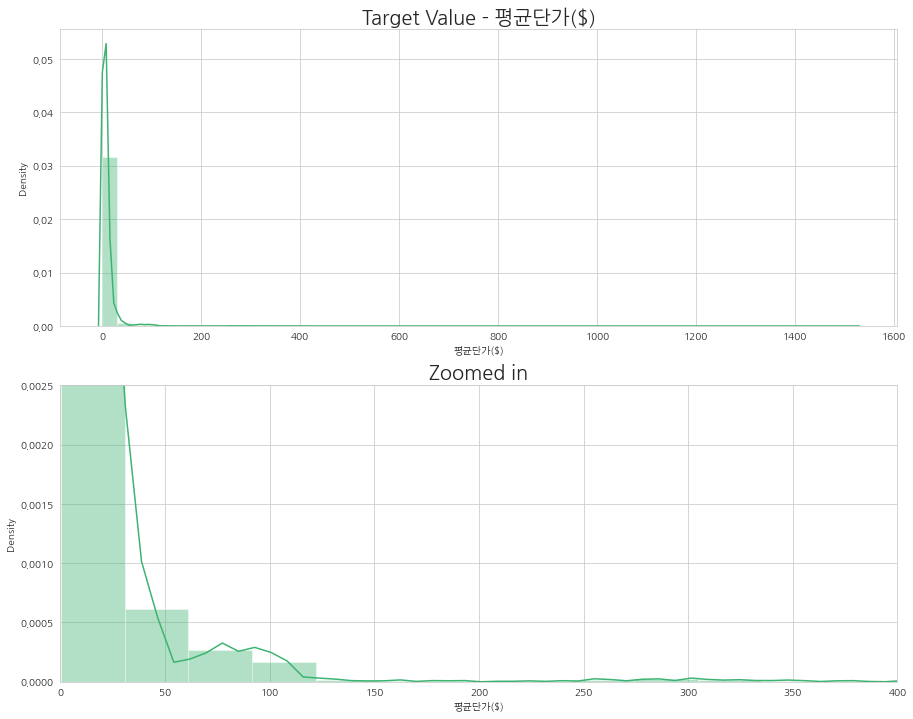

In [130]:
# 평균단가 분포

plt.figure(figsize=(15, 12))

plt.subplot(2, 1, 1)
sns.distplot(df_train['평균단가($)'], color='mediumseagreen')
plt.title("Target Value - 평균단가($)",fontsize=title_size)

plt.subplot(2, 1, 2)
sns.distplot(df_train['평균단가($)'], color='mediumseagreen')
plt.xlim([0, 400])
plt.ylim([0, 0.0025])
plt.title("Zoomed in",fontsize=title_size)

plt.show()

- 평균, Q1, Q2, Q3 값에 비해 최대값이 매우 크고, std가 굉장히 큰 것으로 보아 치우쳐져서 분포하고 있음을 알 수 있음.

- 75%의 값들은 10 미만

- 대부분의 값들이 50 보다 작은 값을 가지고 있음

- 대부분의 값들이 130 보다 작은 값을 가지고 있음

- 큰 값들의 공통점을 찾아보면 좋을 듯함.

## 기준일

In [131]:
df_train[['기준일']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42073 entries, 0 to 42072
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     42073 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 328.8 KB


In [132]:
df_train['기준일'].describe()

count                   42073
unique                    210
top       2017-09-25 00:00:00
freq                      255
first     2015-12-28 00:00:00
last      2019-12-30 00:00:00
Name: 기준일, dtype: object

In [133]:
print(len(df_train), "data exists between", min(df_train['기준일']), "~", max(df_train['기준일']))

42073 data exists between 2015-12-28 00:00:00 ~ 2019-12-30 00:00:00


In [134]:
df_train['date'] = df_train['기준일'].dt.year.astype('str') + df_train['기준일'].dt.month.astype('str').str.zfill(2)

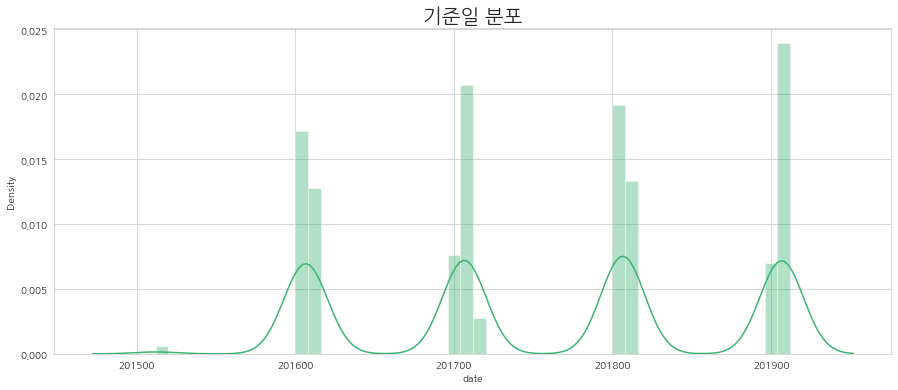

In [135]:
# 년월 기준 기준일 분포

plt.figure(figsize=(15,6))
sns.distplot( df_train['date'], color='mediumseagreen')
plt.title("기준일 분포",fontsize=title_size)
plt.show()

In [136]:
df_train.groupby(df_train['기준일'].dt.year).count() 

,기준일,제품구분,제조국,수출국,수입용도,중분류명 카테고리,어종,상세어종,수입형태,평균단가($),date
기준일,,,,,,,,,,,
2015,199,199,199,199,199,199,199,199,199,199,199
2016,10086,10086,10086,10086,10086,10086,10086,10086,10086,10086,10086
2017,10451,10451,10451,10451,10451,10451,10451,10451,10451,10451,10451
2018,10934,10934,10934,10934,10934,10934,10934,10934,10934,10934,10934
2019,10403,10403,10403,10403,10403,10403,10403,10403,10403,10403,10403


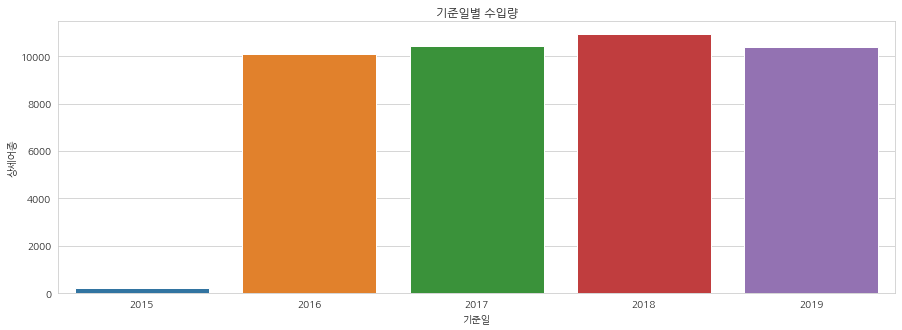

In [137]:
# 기준일별 수입량

plt.figure(figsize=(15,5))
sns.barplot(x = df_train.groupby(df_train['기준일'].dt.year).count().index, y = df_train.groupby(df_train['기준일'].dt.year).count()['상세어종'])
plt.title('기준일별 수입량')
plt.show() 

데이터가 얼마 없는 2015년을 제외한 나머지 년도에선 수입량이 비슷한 것을 알 수 있다.

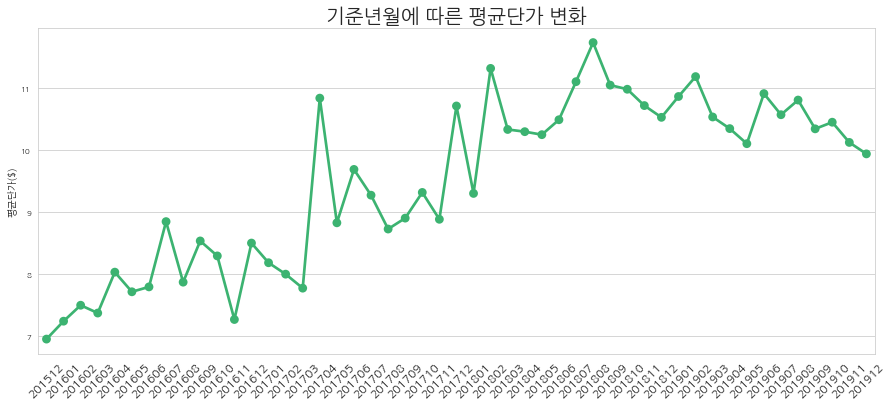

In [138]:
# 기준년월에 따른 평균단가 변화

plt.figure(figsize=(15, 6))
sns.pointplot(x='date', y='평균단가($)', data=df_train, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('기준년월에 따른 평균단가 변화', fontsize=title_size)
plt.show()

- 시간이 지날수록 평균단가가 상승하는 패턴을 보임.

- 2016~2019년 수입량의 큰 차이가 없음에도 평균단가가 상승하는 것으로 보아, 평균단가가 높은 어종의 수입이 상대적으로 증가한 것을 유추해볼 수 있음.

- 가격이 높아지거나 낮아지는 특정 시점들이 존재하지만, 시점들 간의 뚜렷한 패턴이 보이지는 않음.

- 수입형태별 평균단가, 어종별 평균단가처럼 좀 더 세분화해서 볼 필요가 있어보임.

## 제조국 / 수출국

In [139]:
df_train['제조국'].describe()

count     42073
unique       87
top          중국
freq      11029
Name: 제조국, dtype: object

In [140]:
df_train['수출국'].describe()

count     42073
unique       88
top          중국
freq      12008
Name: 수출국, dtype: object

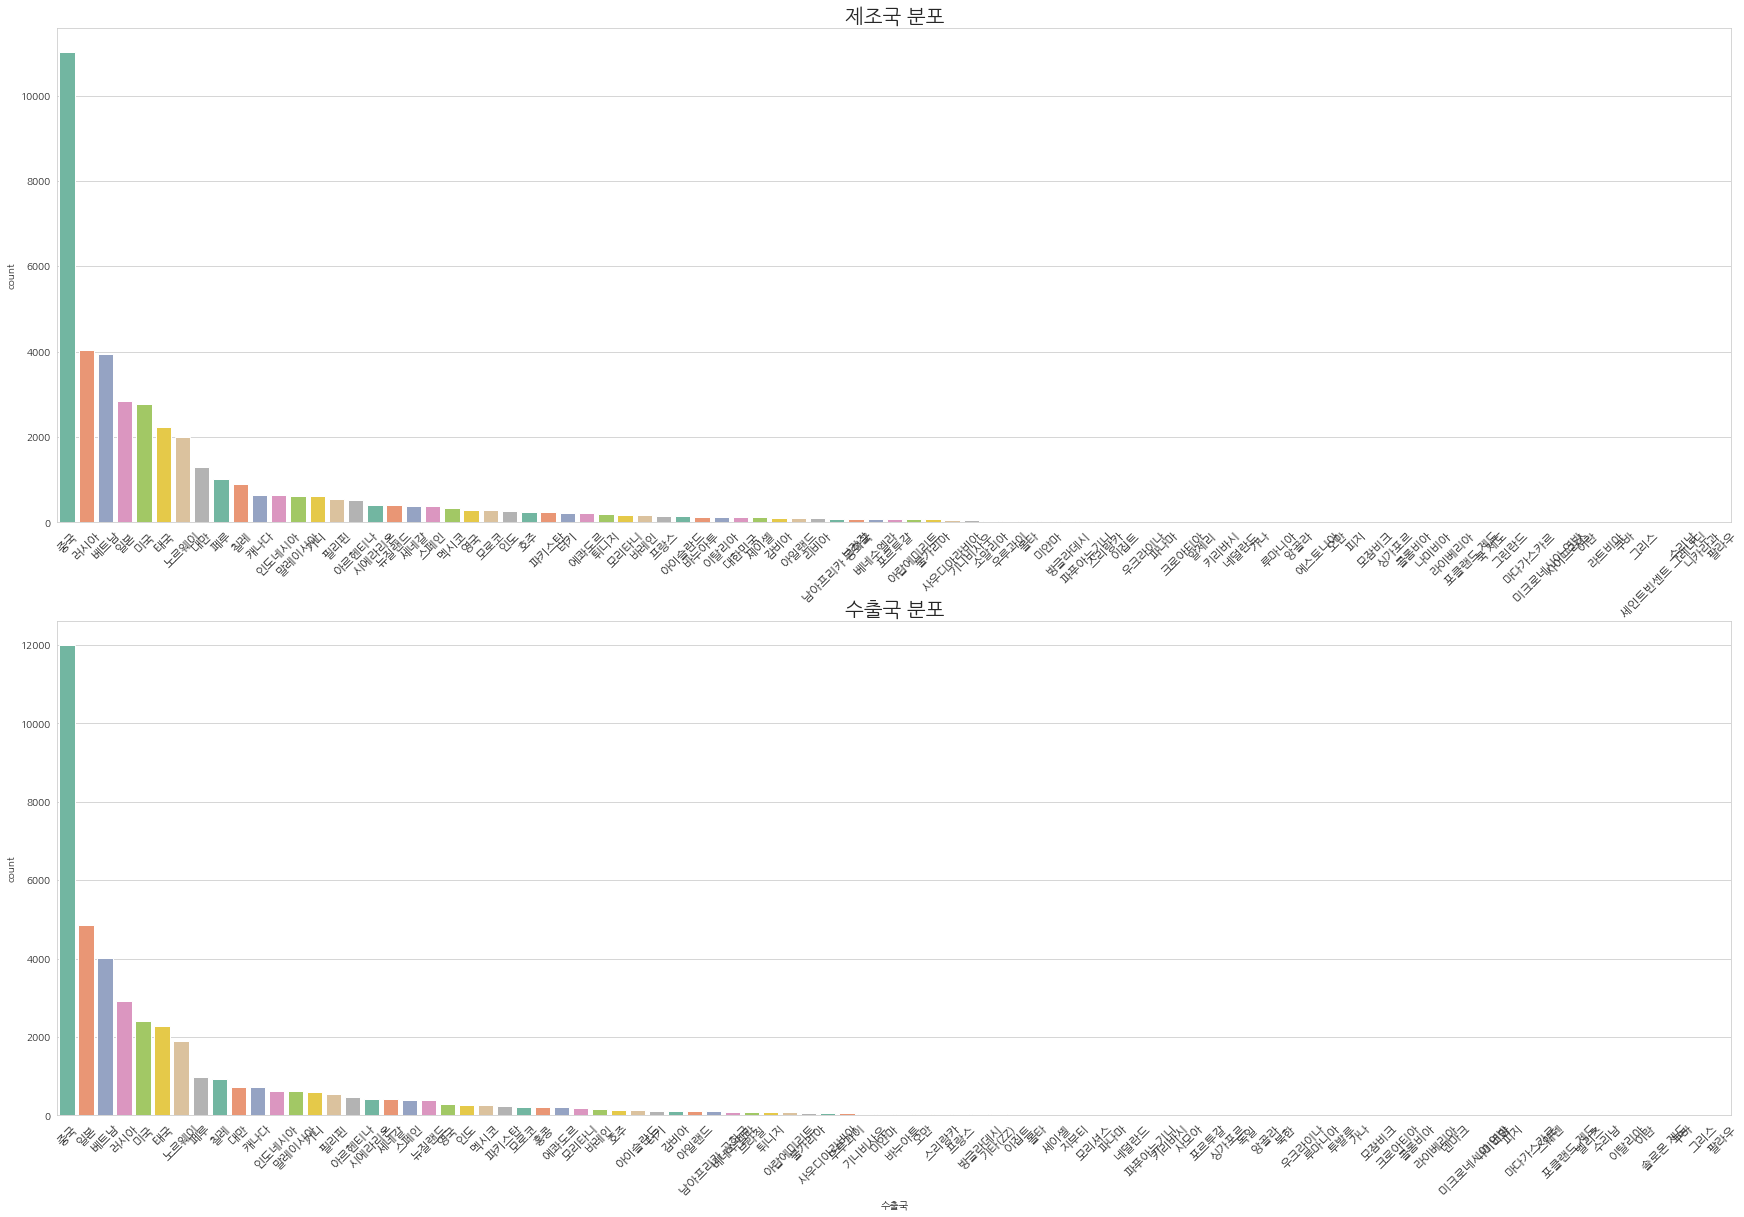

In [141]:
# 제조국 분포

plt.figure(figsize=(30, 20))

plt.subplot(2, 1, 1)
sns.countplot(df_train['제조국'].astype('str').sort_values(), palette=color_palette, order = df_train['제조국'].value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('제조국 분포', fontsize=title_size)

# 수출국 분포

plt.subplot(2, 1, 2)
sns.countplot(df_train['수출국'].astype('str').sort_values(), palette=color_palette, order = df_train['수출국'].value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('수출국 분포', fontsize=title_size)

plt.show()

- 모든 수산물에 대한 제조국, 수출국 분포 그래프

- 제조국, 수출국 모두 가장 비중이 높은 나라는 중국.

- 그 외에, 제조국은 러시아, 베트남,일본, 미국, 태국, 노르웨이 순으로 비중이 높으며, 수출국은 일본, 베트남, 러시아, 미국, 태국, 노르웨이 순으로 비중이 높음.

- 상위 제조국, 수출국 분포는 유사한 것을 알 수 있음.


In [142]:
# df_train['제조국'] = df_train['제조국'].astype('category')
# df_train['수출국'] = df_train['수출국'].astype('category')

In [143]:
# plt.figure(figsize=(30, 30))
# sns.boxplot(x='제조국', y='평균단가($)', data=df_train, palette=color_palette)
# plt.xticks(rotation=60, fontsize=12)
# plt.title('제조국', fontsize=title_size)

## 수입용도

In [144]:
df_train.수입용도.describe()

count     42073
unique        5
top         판매용
freq      39278
Name: 수입용도, dtype: object

In [145]:
print(df_train.수입용도.value_counts())

판매용         39278
자사제품제조용      1726
외화획득용 원료      911
합작            144
반송품(기타)        14
Name: 수입용도, dtype: int64


In [146]:
df_train['수입용도'] = df_train['수입용도'].astype('category')

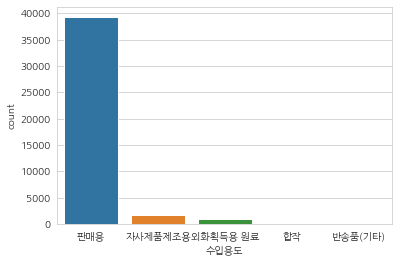

In [147]:
# 수입용도 분포

sns.countplot(x='수입용도',data = df_train, order = df_train['수입용도'].value_counts().index)
plt.show()

- 수입용도는 판매용, 자사제품제조용, 외화획득용 원료, 합작, 반송품(기타) 순으로 많음.

- 판매용에 값이 몰려있어 해당 컬럼을 변수로 사용 시 고려해야함.

##중분류명

In [148]:
df_train['중분류명 카테고리'].describe()

count     42073
unique        7
top          어류
freq      21339
Name: 중분류명 카테고리, dtype: object

In [149]:
df_train['중분류명 카테고리'].value_counts()

어류             21339
갑각류             7298
연체류 해물모듬        6772
패류 멍게류          5097
알 곤이류           1037
젓갈류 해조류 해파리      467
기타 수입식품           63
Name: 중분류명 카테고리, dtype: int64

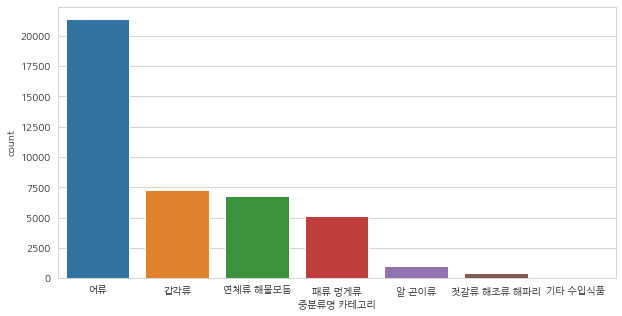

In [150]:
# 중분류명 카테고리 분포

plt.figure(figsize=(10,5))
sns.countplot(x='중분류명 카테고리',data = df_train, order = df_train['중분류명 카테고리'].value_counts().index)
plt.show()

- 중분류명 카테고리는 어류, 갑각류, 연체류 해물모듬, 패류 멍게류, 알 곤이류, 젓갈류 해조류 해파리, 기타 수입식품 순으로 많음.

- 어류에 값이 몰려있어 해당 컬럼을 변수로 사용 시 고려해야함.

Text(0.5, 1.0, '어류의 CATEGORY')

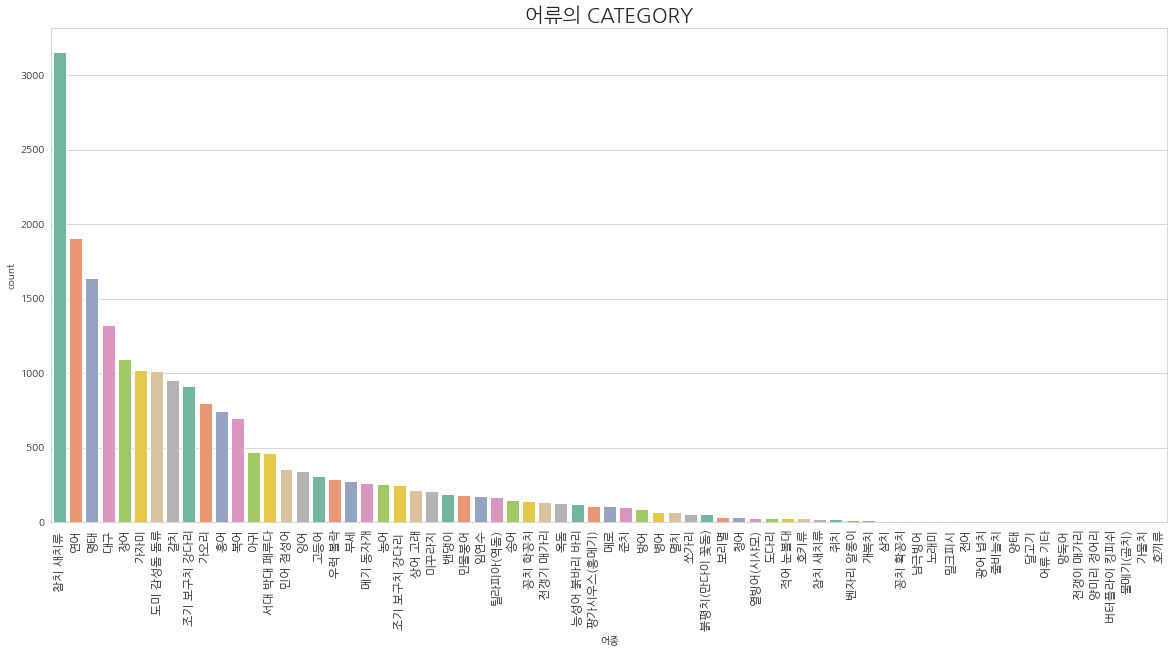

In [151]:
# 어류만 분류
is_fish = df_train['중분류명 카테고리'].str.contains("어류",na=False)
df_fish = df_train[is_fish]

plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
sns.countplot(df_fish['어종'].astype('str').sort_values(), palette=color_palette, order = df_fish['어종'].astype('str').value_counts().index)
plt.xticks(rotation=90, fontsize=12)
plt.title('어류의 CATEGORY', fontsize=title_size)

In [152]:
print(df_fish['어종'].value_counts())

참치 새치류       3159
연어           1905
명태           1640
대구           1325
장어           1093
             ... 
양미리 정어리         2
버터플라이 킹피쉬       1
물메기(곰치)         1
가물치             1
호끼류             1
Name: 어종, Length: 69, dtype: int64


## 수입형태

In [153]:
df_train['수입형태'].describe()

count     42073
unique       78
top          냉동
freq      13568
Name: 수입형태, dtype: object

In [154]:
df_train['수입형태'].value_counts()

냉동                13568
활                  8280
냉장                 4682
냉동,살,자숙            1431
냉동,살               1044
                  ...  
냉동,개아지살,살,포장횟감        2
자숙,건조                 1
냉장,간                  1
냉동,자숙,절단,횟감           1
건조,지느러미,자숙            1
Name: 수입형태, Length: 78, dtype: int64

- 유사한 유형 존재 ex) 머리 / 머리살 / 머리_외화획득용
- 카테고리를 묶을 수 있을지 살펴보기
- 여러개의 용도로 들어오는 경우 고려... 용도의 수를 새로운 변수로 사용하면 좋을듯

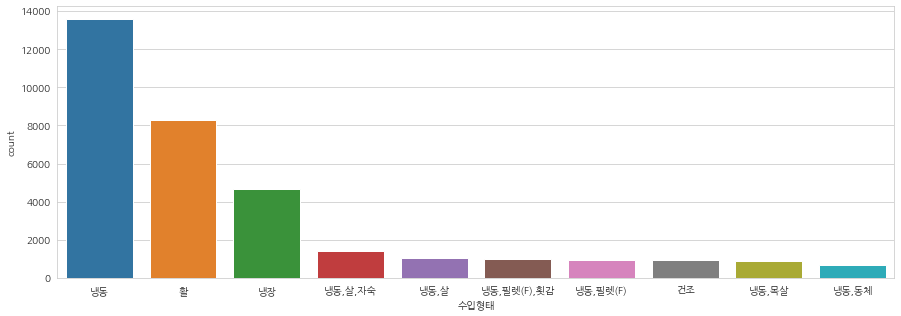

In [239]:
# 수입량 상위 10개 수입형태 분포

plt.figure(figsize=(15,5))
sns.countplot(x='수입형태',data = df_train, order = df_train['수입형태'].value_counts().index[:10])
plt.show()

In [156]:
# 수입형태를 세부적으로 분리

import_type_list = set()
for tmp in df_train.수입형태.unique():
    for a in tmp.split(','):
        import_type_list.add(a)

print(*import_type_list)

눈살 필렛(F) 살 슬라이스(S) 지느러미 냉동 포장횟감 목살 한쪽껍질붙은 곤이 외투막 캐비아대용 알 다리 개아지살 머리_외화획득용 건조 머리살 간 동체 머리 집게다리 훈제 볼살 냉장 횟감 내장 자숙 염장 꼬리_외화획득용 창난 줄기 껍질 턱살 활 절단 난포선


In [157]:
# for name in import_type_list:
#     df_train[name] = 0
#     df_train.loc[df_train['수입형태'].str.contains(name, regex=False), name] = 1

In [158]:
# df_train.head()

## 어종

In [159]:
df_train['어종'].describe()

count     42073
unique      113
top          새우
freq       4141
Name: 어종, dtype: object

In [160]:
# 중분류명 카테고리별 상세어종

with pd.option_context('display.max_rows', df_train.shape[0]+1):
    display(df_train[['중분류명 카테고리', '어종']].groupby(['중분류명 카테고리', '어종']).count())

Empty DataFrame
Columns: []
Index: [(갑각류, 가재 랍스타), (갑각류, 게), (갑각류, 새우), (기타 수입식품, 자라), (알 곤이류, 날치알), (알 곤이류, 대구알), (알 곤이류, 명란(명태알)), (알 곤이류, 샛돔류알), (알 곤이류, 성게알), (알 곤이류, 연어알), (알 곤이류, 열빙어(시샤모)알), (알 곤이류, 은민대구알), (알 곤이류, 청어알), (알 곤이류, 호키(새꼬리민태)알), (어류, 가물치), (어류, 가오리), (어류, 가자미), (어류, 갈치), (어류, 개복치), (어류, 고등어), (어류, 광어 넙치), (어류, 꽁치 학꽁치), (어류, 꽁치 확꽁치), (어류, 남극빙어), (어류, 노래미), (어류, 농어), (어류, 능성어 붉바리 바리), (어류, 달고기), (어류, 대구), (어류, 도다리), (어류, 도미 감성돔 돔류), (어류, 망둑어), (어류, 메기 동자개), (어류, 메로), (어류, 멸치), (어류, 명태), (어류, 물메기(곰치)), (어류, 미꾸라지), (어류, 민물붕어), (어류, 민어 점성어), (어류, 밀크피시), (어류, 방어), (어류, 밴댕이), (어류, 버터플라이 킹피쉬), (어류, 벤자리 알롱이), (어류, 병어), (어류, 보리멸), (어류, 복어), (어류, 부세), (어류, 붉평치(만다이 꽃돔)), (어류, 삼치), (어류, 상어 고래), (어류, 서대 박대 페루다), (어류, 송어), (어류, 쏘가리), (어류, 아귀), (어류, 양미리 정어리), (어류, 양태), (어류, 어류 기타), (어류, 연어), (어류, 열빙어(시샤모)), (어류, 옥돔), (어류, 우럭 볼락), (어류, 임연수), (어류, 잉어), (어류, 장어), (어류, 적어 눈볼대), (어류, 전갱기 매가리), (어류, 전갱이 매가리), (어류, 전어), (어류, 조기 보구치 강다리), (어류, 조기 보구치 강다리 ), (어류, 준치), (어류, 줄비늘치), (어류, 쥐치), (어류, 참치 새치류), (어류, 참치 새치류 ), (어류, 청어), (어류, 틸라피아(역돔)), (어류, 팡가시우스(홍메기)), (어류, 호끼류), (어류, 호키류), (어류, 홍어), (연체류 해물모듬, 갑오징어), (연체류 해물모듬, 꼴뚜기), (연체류 해물모듬, 낙지), (연체류 해물모듬, 문어), (연체류 해물모듬, 오징어), (연체류 해물모듬, 쭈꾸미), (연체류 해물모듬, 해물모둠), (젓갈류 해조류 해파리, 가사리), (젓갈류 해조류 해파리, 고시래기), (젓갈류 해조류 해파리, 김), (젓갈류 해조류 해파리, 다시마), (젓갈류 해조류 해파리, 미역), (젓갈류 해조류 해파리, 톳), (젓갈류 해조류 해파리, 해초), (젓갈류 해조류 해파리, 해파리), (패류 멍게류, 가리비), (패류 멍게류, 개불), ...]

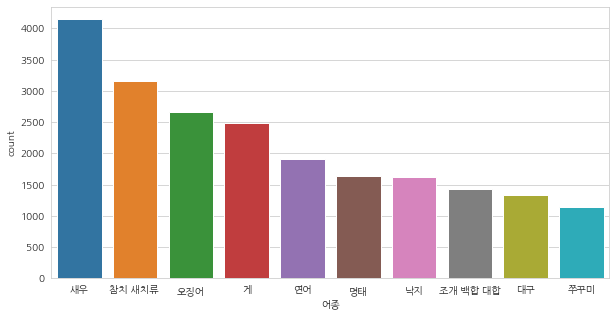

In [161]:
# 수입량 상위 10개 어종 분포

plt.figure(figsize=(10,5))
sns.countplot(x='어종',data = df_train, order = df_train['어종'].value_counts().index[:10])
plt.show()

- 어종은 새우, 참치 새치류, 오징어, 게, 연어 순으로 많음.

(5.0, 12.0)

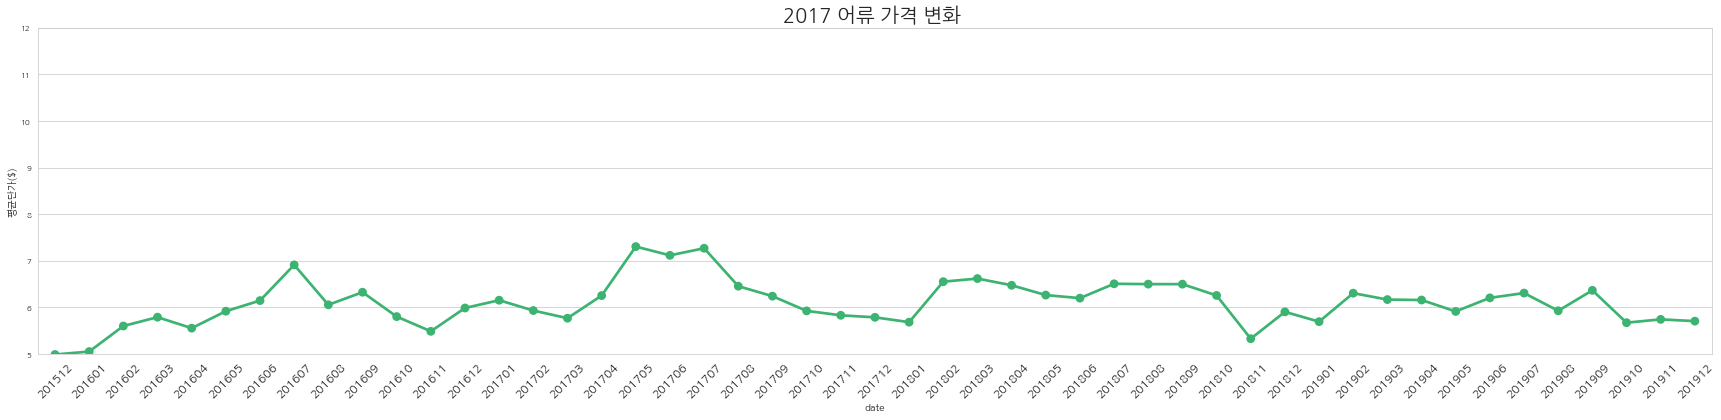

In [162]:
df_fish['is_2017'] = np.where((df_fish.date >= '201512') & (df_fish.date <= '201912') ,'1','0')
is_2017 = df_fish['is_2017'].str.contains('1',na=False)
df_2017 = df_fish[is_2017]
df_2017['isnot_tuna'] = np.where(df_2017['어종'].str.contains('참치',na=False) ,'1','0')
isnot_tuna = df_2017['isnot_tuna'].str.contains('0',na=False)
df_notuna = df_2017[isnot_tuna]


df_two = df_notuna['평균단가($)'].groupby(df_notuna['어종'])
# print("---size---")
# print(df_two.size())
# print("---max---")
# print(df_two.max())
# print("---min---")
# print(df_two.min())
# print("---mean---")
# print(df_two.mean())
# print("---median---")
# print(df_two.median())


plt.figure(figsize=(30, 6))

sns.pointplot(x='date', y='평균단가($)', data=df_notuna, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.title('2017 어류 가격 변화 ', fontsize=title_size)
plt.ylim(5,12)

### 주요 어종 (오징어, 연어, 새우)

Text(0.5, 1.0, '어류의 CATEGORY')

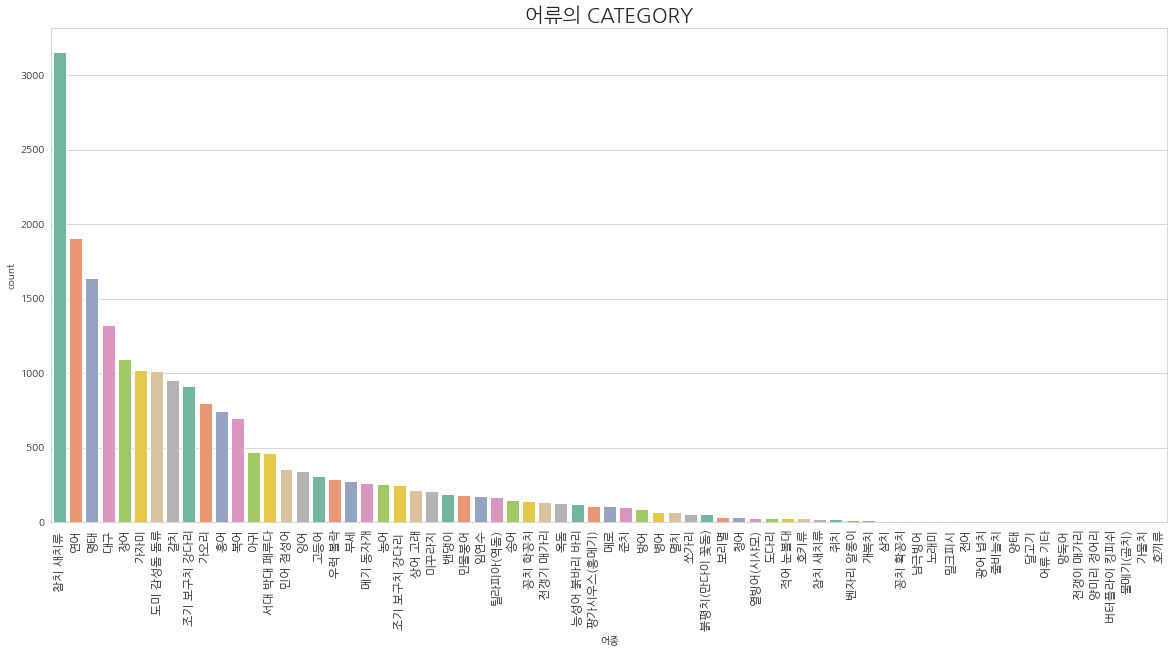

In [240]:
# 어류만 분류
is_fish = df_train['중분류명 카테고리'].str.contains("어류",na=False)
df_fish = df_train[is_fish]

plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
sns.countplot(df_fish['어종'].astype('str').sort_values(), palette=color_palette,order=df_fish['어종'].astype('str').value_counts().index)
plt.xticks(rotation=90, fontsize=12)
plt.title('어류의 CATEGORY', fontsize=title_size)

In [164]:
print(df_fish['어종'].value_counts())

참치 새치류       3159
연어           1905
명태           1640
대구           1325
장어           1093
             ... 
양미리 정어리         2
버터플라이 킹피쉬       1
물메기(곰치)         1
가물치             1
호끼류             1
Name: 어종, Length: 69, dtype: int64


#### 오징어

In [165]:
# 오징어의 제조국 점유율

df_train[df_train['상세어종']=='오징어']['제조국'].value_counts()/sum(df_train[df_train['상세어종']=='오징어']['제조국'].value_counts()) 

페루       0.384186
중국       0.251163
칠레       0.250233
대만       0.028837
대한민국     0.026512
아르헨티나    0.026047
뉴질랜드     0.020465
러시아      0.003721
미국       0.002791
에콰도르     0.001860
바누아투     0.000930
우루과이     0.000930
베트남      0.000930
인도네시아    0.000930
나미비아     0.000465
Name: 제조국, dtype: float64

In [166]:
# 오징어의 수출국 점유율

df_train[df_train['상세어종']=='오징어']['수출국'].value_counts()/sum(df_train[df_train['상세어종']=='오징어']['수출국'].value_counts()) 

페루           0.370233
중국           0.286977
칠레           0.261395
대만           0.028372
아르헨티나        0.020465
뉴질랜드         0.018140
러시아          0.003721
미국           0.002791
에콰도르         0.001860
일본           0.001395
우루과이         0.000930
베트남          0.000930
인도네시아        0.000930
바누아투         0.000465
남아프리카 공화국    0.000465
태국           0.000465
스페인          0.000465
Name: 수출국, dtype: float64

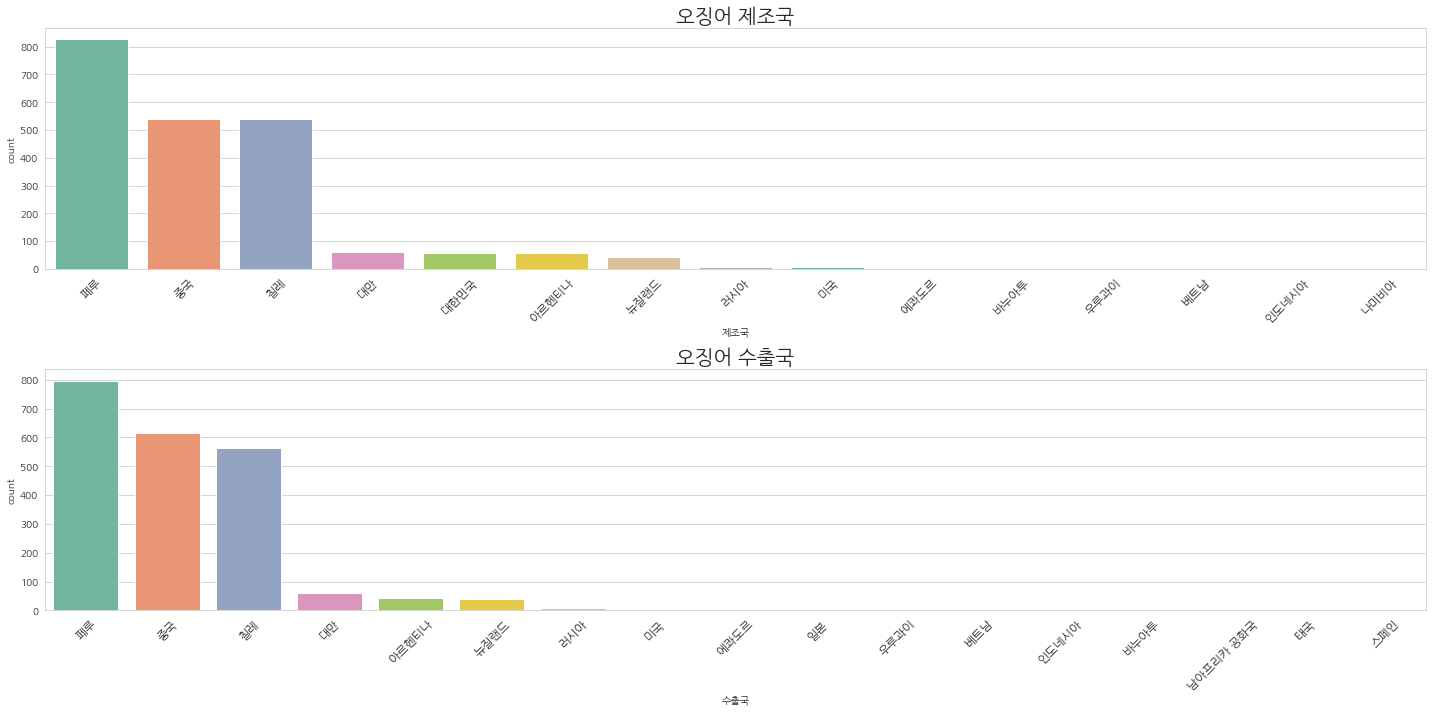

In [167]:
# 오징어 제조국

plt.figure(figsize=(20, 10))

plt.subplot(211)
sns.countplot(df_train[df_train['상세어종']=='오징어']['제조국'].astype('str').sort_values(), palette=color_palette, order = df_train[df_train['상세어종']=='오징어']['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('오징어 제조국', fontsize=title_size)

# 오징어 수출국

plt.subplot(212)
sns.countplot(df_train[df_train['상세어종']=='오징어']['수출국'].astype('str').sort_values(), palette=color_palette, order = df_train[df_train['상세어종']=='오징어']['수출국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('오징어 수출국', fontsize=title_size)

plt.tight_layout()

- 오징어 제조국 및 수출국 점유율
-  오징어 주요 제조국 및 수출국 : 페루,중국,칠레 (91%)
- 주요 수출국별 평균단가를 시각화하여 상관관계를 알아보고자 함.

In [168]:
all_squid_price = df_train[df_train['상세어종']=='오징어'].groupby(by='기준일').mean()['평균단가($)'] # 전체 오징어 평균단가
peru_squid_price = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='페루'].groupby(by='기준일').mean()['평균단가($)'] # 페루 오징어 평균단가
china_squid_price = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='중국'].groupby(by='기준일').mean()['평균단가($)'] # 중국 오징어 평균단가
chile_squid_price = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='칠레'].groupby(by='기준일').mean()['평균단가($)'] # 칠레 오징어 평균단가

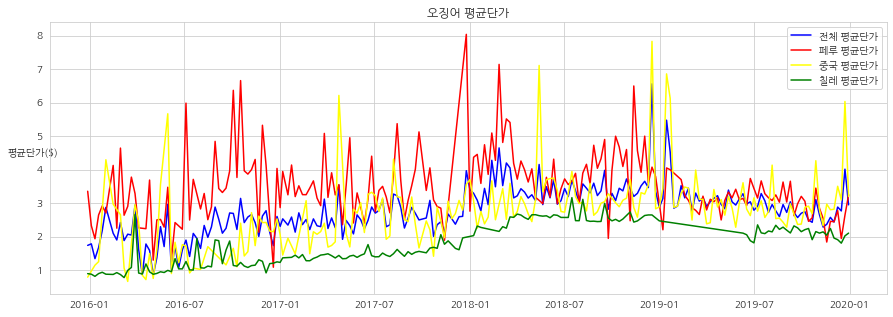

In [169]:
plt.figure(figsize=(15,5))

plt.title('오징어 평균단가')

plt.plot(all_squid_price,color='blue',label='전체 평균단가')
plt.plot(peru_squid_price,color='red',label='페루 평균단가')
plt.plot(china_squid_price,color='yellow',label='중국 평균단가')
plt.plot(chile_squid_price,color='green',label='칠레 평균단가')

plt.legend(loc='best')
plt.ylabel('평균단가($)',rotation=0)

plt.show()

오징어 평균단가는 **주요 수출국들(페루,중국,칠레)의 평균단가와 높은 상관관계**를 가지는 듯함. (올라갈때 같이 올라가고 내려갈때 같이 내려감)

In [170]:
pd.DataFrame({'all':all_squid_price,
             'peru':peru_squid_price,
             'china':china_squid_price,
             'chile':chile_squid_price}).corr()

,all,peru,china,chile
all,1.000000,0.510630,0.785898,0.727521
peru,0.510630,1.000000,0.109155,0.238574
china,0.785898,0.109155,1.000000,0.501766
chile,0.727521,0.238574,0.501766,1.000000


실제로 오징어 평균단가는 페루,중국,칠레 평균단가와 높은 상관관계를 띄고 있음.

In [171]:
all_squid_count = df_train[df_train['상세어종']=='오징어'].groupby(by='기준일')['상세어종'].count() # 전체 오징어 수입량
peru_squid_count = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='페루'].groupby(by='기준일')['상세어종'].count() # 페루 오징어 수입량
china_squid_count = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='중국'].groupby(by='기준일')['상세어종'].count() # 중국 오징어 수입량
chile_squid_count = df_train[df_train['상세어종']=='오징어'][df_train['수출국']=='칠레'].groupby(by='기준일')['상세어종'].count() # 칠레 오징어 수입량

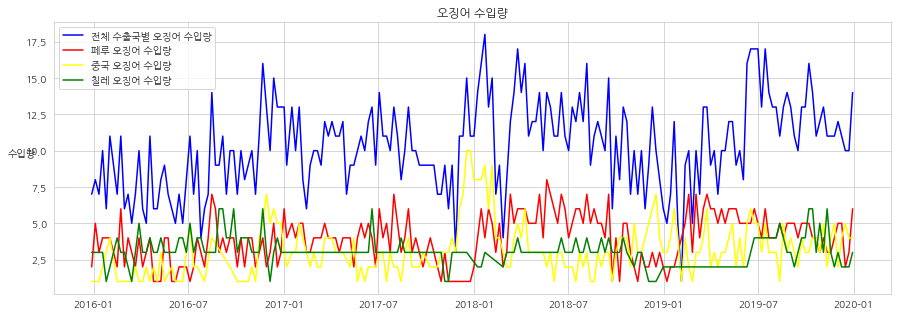

In [172]:
plt.figure(figsize=(15,5))

plt.title('오징어 수입량')

plt.plot(all_squid_count,color='blue',label='전체 수출국별 오징어 수입량')
plt.plot(peru_squid_count,color='red',label='페루 오징어 수입량')
plt.plot(china_squid_count,color='yellow',label='중국 오징어 수입량')
plt.plot(chile_squid_count,color='green',label='칠레 오징어 수입량')


plt.legend(loc='best')
plt.ylabel('수입량',rotation=0)

plt.show()

오징어 수입량 **주요 수출국들(페루,중국,칠레)의 수입량과 어느정도 상관관계**를 보이는 듯함. 특히, 페루와 높은 상관관계를 보이는 듯함.

In [173]:
pd.DataFrame({'all':all_squid_count,
             'peru':peru_squid_count,
             'china':china_squid_count,
             'chile':chile_squid_count}).corr()

,all,peru,china,chile
all,1.000000,0.619937,0.529920,0.227335
peru,0.619937,1.000000,0.053783,0.100801
china,0.529920,0.053783,1.000000,-0.190133
chile,0.227335,0.100801,-0.190133,1.000000


- 실제로 오징어 수입량은 페루,중국 수입량과 높은 상관관계를 띄고 있음.
- 칠레는 상대적으로 낮은 상관관계

#### 연어




In [174]:
# 연어만 분류
is_salmon = df_fish['어종'].str.contains("연어",na=False)
df_salmon = df_fish[is_salmon]

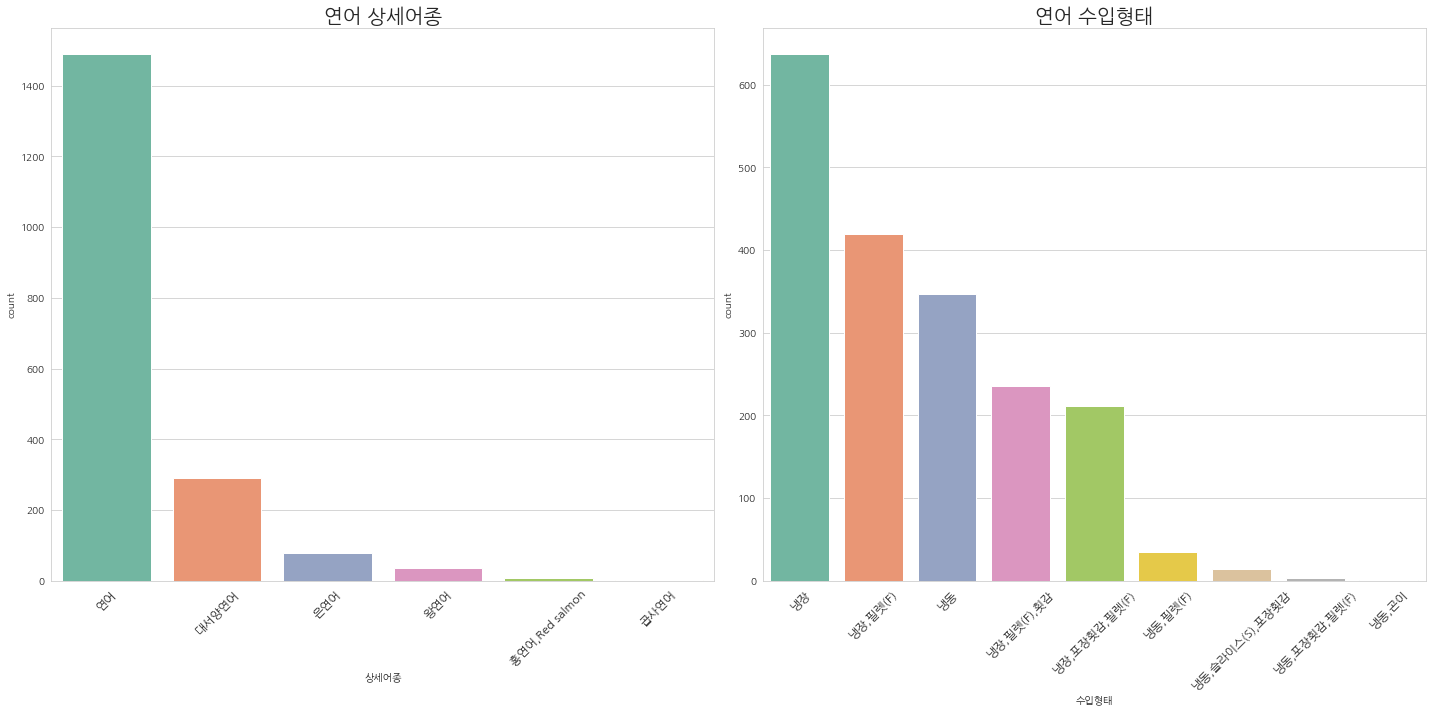

In [175]:
# 연어
df_salmon.loc[df_salmon['제조국']==df_salmon['수출국'], "comp"] = '같음'
df_salmon.loc[df_salmon['제조국']!=df_salmon['수출국'], "comp"] = '다름'

# 연어 상세어종 및 수입형태 분포

plt.figure(figsize=(20, 10))

plt.subplot(121)
sns.countplot(df_salmon['상세어종'].astype('str').sort_values(), palette=color_palette, order= df_salmon['상세어종'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 상세어종', fontsize=title_size)

plt.subplot(122)
sns.countplot(df_salmon['수입형태'].astype('str').sort_values(), palette=color_palette, order= df_salmon['수입형태'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 수입형태', fontsize=title_size)

plt.tight_layout()

In [176]:
# 제조국, 수출국 다른곳 찾기
df_salmon.loc[df_salmon['제조국']==df_salmon['수출국'], "comp"] = '같음'
df_salmon.loc[df_salmon['제조국']!=df_salmon['수출국'], "comp"] = '다름'
print(df_salmon['comp'].value_counts())

같음    1867
다름      38
Name: comp, dtype: int64


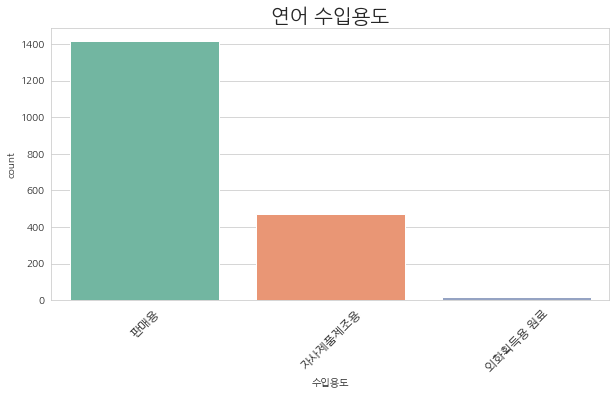

In [177]:
plt.figure(figsize=(10, 5))

sns.countplot(df_salmon['수입용도'].astype('str').sort_values(), palette=color_palette, order= df_salmon['수입용도'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 수입용도', fontsize=title_size)
plt.show()

제조국과 판매국에 따라서 뭐가 다를지 보고싶음

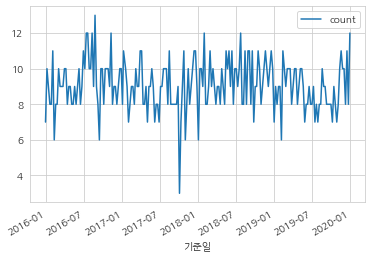

In [178]:
df_salmon.groupby('기준일')['제조국'].describe()['count'].plot(legend='count')

In [179]:
is_one = df_salmon['수입용도'].str.contains("외화획득용 원료",na=False)
df_one = df_salmon[is_one]

df_one

,기준일,제품구분,제조국,수출국,수입용도,중분류명 카테고리,어종,상세어종,수입형태,평균단가($),date,comp
8639,2016-11-07,수산물,러시아,러시아,외화획득용 원료,어류,연어,은연어,냉동,3.200000,201611,같음
8750,2016-11-07,수산물,러시아,러시아,외화획득용 원료,어류,연어,연어,냉동,2.884304,201611,같음
10135,2016-12-26,수산물,러시아,러시아,외화획득용 원료,어류,연어,연어,냉동,4.002672,201612,같음
18366,2017-10-16,수산물,러시아,러시아,외화획득용 원료,어류,연어,연어,냉동,4.633319,201710,같음
18590,2017-10-23,수산물,러시아,러시아,외화획득용 원료,어류,연어,"홍연어,Red salmon",냉동,7.500000,201710,같음
20345,2017-12-18,수산물,미국,미국,외화획득용 원료,어류,연어,"홍연어,Red salmon",냉동,6.410003,201712,같음
30224,2018-11-19,수산물,러시아,러시아,외화획득용 원료,어류,연어,곱사연어,냉동,1.850974,201811,같음
30767,2018-12-03,수산물,러시아,러시아,외화획득용 원료,어류,연어,연어,냉동,3.259972,201812,같음
31629,2018-12-31,수산물,러시아,러시아,외화획득용 원료,어류,연어,은연어,냉동,3.200000,201812,같음
32701,2019-02-11,수산물,러시아,러시아,외화획득용 원료,어류,연어,연어,냉동,1.900000,201902,같음


In [180]:
is_one = df_salmon['수입용도'].str.contains("자사제품제조용",na=False)
df_one = df_salmon[is_one]

df_one

,기준일,제품구분,제조국,수출국,수입용도,중분류명 카테고리,어종,상세어종,수입형태,평균단가($),date,comp
174,2015-12-28,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,"냉장,필렛(F)",13.425826,201512,같음
234,2016-01-04,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,냉장,8.966241,201601,같음
389,2016-01-04,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,"냉장,필렛(F)",13.760151,201601,같음
535,2016-01-11,수산물,미국,미국,자사제품제조용,어류,연어,곱사연어,냉동,2.149987,201601,같음
547,2016-01-11,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,냉장,8.846151,201601,같음
...,...,...,...,...,...,...,...,...,...,...,...,...
41663,2019-12-16,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,"냉장,필렛(F)",21.650703,201912,같음
41819,2019-12-23,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,냉장,10.663913,201912,같음
41876,2019-12-23,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,"냉장,필렛(F)",15.624160,201912,같음
42044,2019-12-30,수산물,노르웨이,노르웨이,자사제품제조용,어류,연어,연어,냉장,11.128269,201912,같음


In [181]:
is_one = df_salmon['수입용도'].str.contains("판매용",na=False)
df_one = df_salmon[is_one]

df_one

,기준일,제품구분,제조국,수출국,수입용도,중분류명 카테고리,어종,상세어종,수입형태,평균단가($),date,comp
27,2015-12-28,수산물,노르웨이,노르웨이,판매용,어류,연어,대서양연어,냉동,6.204593,201512,같음
59,2015-12-28,수산물,칠레,칠레,판매용,어류,연어,대서양연어,냉동,4.800021,201512,같음
74,2015-12-28,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,필렛(F)",12.936815,201512,같음
129,2015-12-28,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,포장횟감,필렛(F)",19.146755,201512,같음
168,2015-12-28,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,필렛(F),횟감",12.082384,201512,같음
...,...,...,...,...,...,...,...,...,...,...,...,...
41994,2019-12-30,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,필렛(F)",16.495971,201912,같음
41995,2019-12-30,수산물,노르웨이,노르웨이,판매용,어류,연어,연어,"냉장,필렛(F),횟감",18.350634,201912,같음
42008,2019-12-30,수산물,노르웨이,노르웨이,판매용,어류,연어,대서양연어,냉동,7.486208,201912,같음
42015,2019-12-30,수산물,칠레,칠레,판매용,어류,연어,대서양연어,냉동,5.979193,201912,같음


제조국과 수출국이 다른곳은 판매용 밖에없다

---size---
수입용도
반송품(기타)        0
외화획득용 원료      16
자사제품제조용      474
판매용         1415
합작             0
Name: 평균단가($), dtype: int64
---sum---
수입용도
반송품(기타)         0.000000
외화획득용 원료       55.674867
자사제품제조용      6230.015117
판매용         19436.309034
합작              0.000000
Name: 평균단가($), dtype: float64
---mean---
수입용도
반송품(기타)           NaN
외화획득용 원료     3.479679
자사제품제조용     13.143492
판매용         13.735907
합작                NaN
Name: 평균단가($), dtype: float64
---median---
수입용도
반송품(기타)           NaN
외화획득용 원료     3.229954
자사제품제조용     12.128644
판매용         12.160447
합작                NaN
Name: 평균단가($), dtype: float64


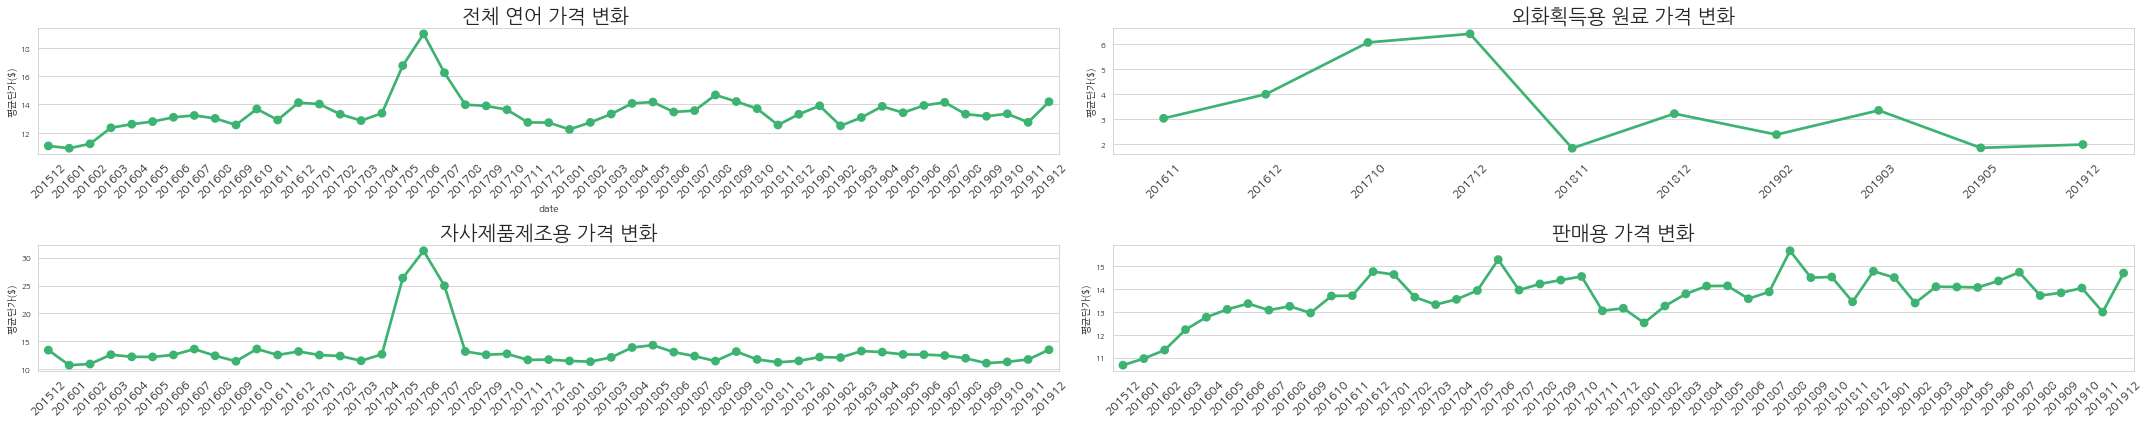

In [182]:
# 용도별 가격 정보
df_one = df_salmon['평균단가($)'].groupby(df_salmon['수입용도'])
print("---size---")
print(df_one.size())
print("---sum---")
print(df_one.sum())
print("---mean---")
print(df_one.mean())
print("---median---")
print(df_one.median())

plt.figure(figsize=(30, 6))

plt.subplot(221)
sns.pointplot(x='date', y='평균단가($)', data=df_salmon, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.title('전체 연어 가격 변화 ', fontsize=title_size)
#plt.ylim(0,36)

is_one = df_salmon['수입용도'].str.contains("외화획득용 원료",na=False)
df_one = df_salmon[is_one]

plt.subplot(222)
sns.pointplot(x='date', y='평균단가($)', data=df_one, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('외화획득용 원료 가격 변화', fontsize=title_size)
#plt.ylim(0,36)

is_one = df_salmon['수입용도'].str.contains("자사제품제조용",na=False)
df_one = df_salmon[is_one]

plt.subplot(223)
sns.pointplot(x='date', y='평균단가($)', data=df_one, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('자사제품제조용 가격 변화', fontsize=title_size)
#plt.ylim(0,36)

is_one = df_salmon['수입용도'].str.contains("판매용",na=False)
df_one = df_salmon[is_one]

plt.subplot(224)
sns.pointplot(x='date', y='평균단가($)', data=df_one, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('판매용 가격 변화', fontsize=title_size)
#plt.ylim(0,36)
plt.tight_layout()

---size---
제조국
노르웨이    92
뉴질랜드     1
영국      12
칠레      13
캐나다      4
Name: 평균단가($), dtype: int64
---max---
제조국
노르웨이    62.457202
뉴질랜드    15.000000
영국      13.178097
칠레       8.559971
캐나다     10.458631
Name: 평균단가($), dtype: float64
---min---
제조국
노르웨이     8.469529
뉴질랜드    15.000000
영국       8.554885
칠레       7.000000
캐나다     10.045957
Name: 평균단가($), dtype: float64
---mean---
제조국
노르웨이    19.559550
뉴질랜드    15.000000
영국      10.327285
칠레       8.272827
캐나다     10.248487
Name: 평균단가($), dtype: float64
---median---
제조국
노르웨이    13.683635
뉴질랜드    15.000000
영국      10.282297
칠레       8.432624
캐나다     10.244680
Name: 평균단가($), dtype: float64


Text(0.5, 1.0, '2017 연어 가격 변화 ')

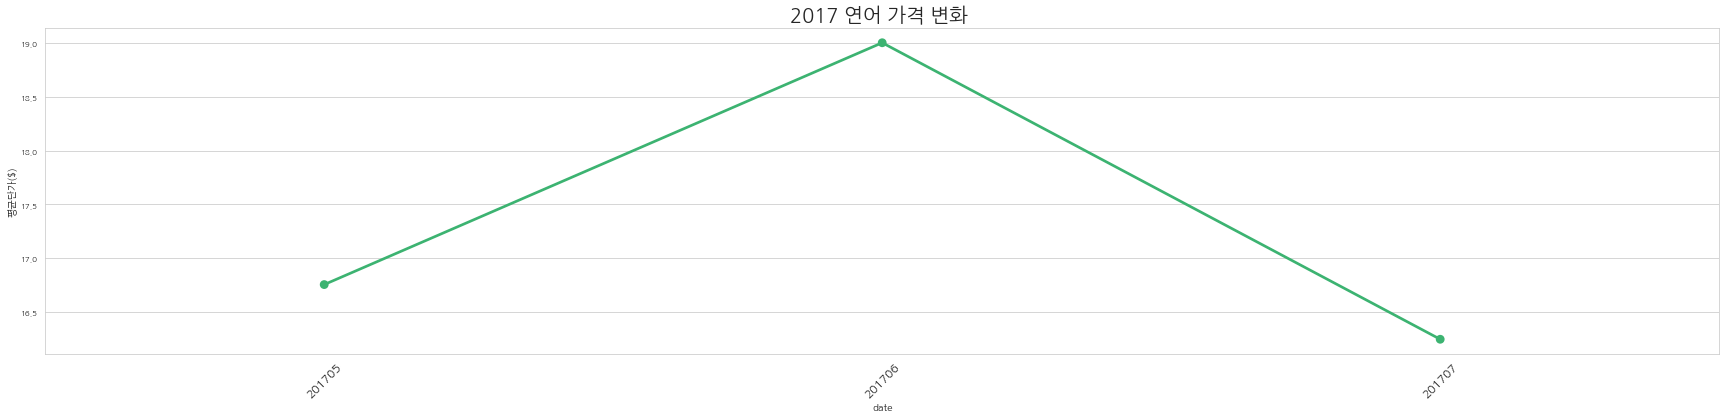

In [183]:
df_salmon['is_2017'] = np.where((df_salmon.date >= '201705') & (df_salmon.date <= '201707') ,'1','0')
is_2017 = df_salmon['is_2017'].str.contains('1',na=False)
df_2017 = df_salmon[is_2017]


df_two = df_2017['평균단가($)'].groupby(df_notuna['제조국'])
print("---size---")
print(df_two.size())
print("---max---")
print(df_two.max())
print("---min---")
print(df_two.min())
print("---mean---")
print(df_two.mean())
print("---median---")
print(df_two.median())


plt.figure(figsize=(30, 6))

sns.pointplot(x='date', y='평균단가($)', data=df_2017, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.title('2017 연어 가격 변화 ', fontsize=title_size)
#plt.ylim(5,12)

- 17년 5~6월에 연어 평균단가가 급격히 상승.
- 같은 기간 판매용, 자사제품제조용 가격이 상승한 것이 가격 상승의 이유로 추정됨.

---size---
수입형태
냉동              19
냉동,필렛(F)         1
냉장             215
냉장,필렛(F)       210
냉장,필렛(F),횟감     29
Name: 평균단가($), dtype: int64
---max---
수입형태
냉동              8.899873
냉동,필렛(F)        9.400137
냉장             13.697301
냉장,필렛(F)       62.457202
냉장,필렛(F),횟감    15.265961
Name: 평균단가($), dtype: float64
---min---
수입형태
냉동              2.149987
냉동,필렛(F)        9.400137
냉장              7.287392
냉장,필렛(F)       12.087304
냉장,필렛(F),횟감     6.056909
Name: 평균단가($), dtype: float64
---mean---
수입형태
냉동              6.685064
냉동,필렛(F)        9.400137
냉장             10.216443
냉장,필렛(F)       16.899194
냉장,필렛(F),횟감    12.008032
Name: 평균단가($), dtype: float64
---median---
수입형태
냉동              6.800000
냉동,필렛(F)        9.400137
냉장             10.001942
냉장,필렛(F)       15.153383
냉장,필렛(F),횟감    12.025189
Name: 평균단가($), dtype: float64


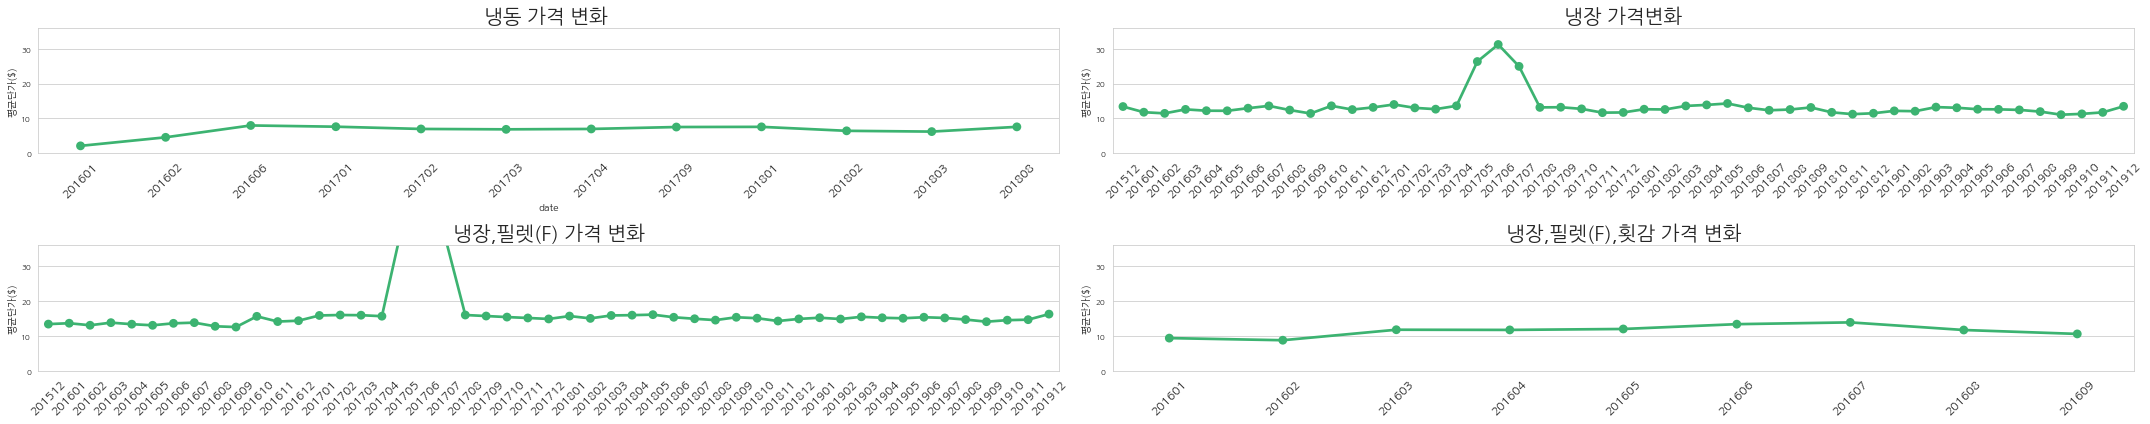

In [184]:
# 자사제품제조용으로 p_import_type 분석
is_one = df_salmon['수입용도'].str.contains("자사제품제조용",na=False)
df_one = df_salmon[is_one]

df_one

df_two = df_one['평균단가($)'].groupby(df_one['수입형태'])
print("---size---")
print(df_two.size())
print("---max---")
print(df_two.max())
print("---min---")
print(df_two.min())
print("---mean---")
print(df_two.mean())
print("---median---")
print(df_two.median())


plt.figure(figsize=(30, 6))

is_one = df_one['수입형태'].str.contains("냉동",na=False)
df_two = df_one[is_one]

plt.subplot(221)
sns.pointplot(x='date', y='평균단가($)', data=df_two, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.title('냉동 가격 변화 ', fontsize=title_size)
plt.ylim(0,36)

is_one = df_one['수입형태'].str.contains("냉장",na=False)
df_two = df_one[is_one]

plt.subplot(222)
sns.pointplot(x='date', y='평균단가($)', data=df_two, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('냉장 가격변화', fontsize=title_size)
plt.ylim(0,36)

is_one = df_one['수입형태'].str.contains("냉장,필렛",na=False)
df_two = df_one[is_one]

plt.subplot(223)
# plt.plot(df_two['date'],df_two['P_PRICE'])

sns.pointplot(x='date', y='평균단가($)', data=df_two, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('냉장,필렛(F) 가격 변화', fontsize=title_size)
plt.ylim(0,36)

is_one = df_one['수입형태'].str.contains("횟감",na=False)
df_two = df_one[is_one]

plt.subplot(224)
sns.pointplot(x='date', y='평균단가($)', data=df_two, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)
plt.xlabel('')
plt.title('냉장,필렛(F),횟감 가격 변화', fontsize=title_size)
plt.ylim(0,36)

plt.tight_layout()

- 냉장,필렛(F),횟감은 16년도, 냉동은 16,17,18년도 데이터만 존재.
- 자사제품제조용의 수입형태별 연어 평균단가 조사 결과, 냉장 및 냉장,필렛의 평균단가가 17년 5 ~ 6월에 상승하여 17년 5 ~ 6월 평균단가가 상승한 것으로 보임.

In [185]:
df_train[df_train['상세어종']=='연어']['제조국'].value_counts()/sum(df_train[df_train['상세어종']=='연어']['제조국'].value_counts()) 

노르웨이     0.858294
영국       0.080591
캐나다      0.034251
호주       0.008059
러시아      0.007388
미국       0.003358
칠레       0.002015
뉴질랜드     0.002015
아이슬란드    0.002015
아일랜드     0.001343
베트남      0.000672
Name: 제조국, dtype: float64

In [186]:
df_train[df_train['상세어종']=='연어']['수출국'].value_counts()/sum(df_train[df_train['상세어종']=='연어']['수출국'].value_counts()) 

노르웨이     0.857623
영국       0.080591
캐나다      0.034251
호주       0.008059
러시아      0.007388
미국       0.002686
칠레       0.002015
뉴질랜드     0.002015
아이슬란드    0.002015
아일랜드     0.001343
베트남      0.001343
중국       0.000672
Name: 수출국, dtype: float64

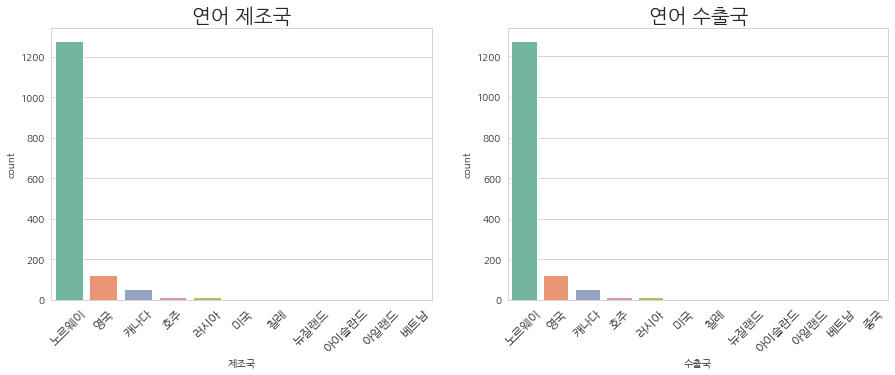

In [187]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(df_train[df_train['상세어종']=='연어']['제조국'].astype('str').sort_values(), palette=color_palette, order= df_train[df_train['상세어종']=='연어']['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 제조국', fontsize=title_size)

plt.subplot(122)
sns.countplot(df_train[df_train['상세어종']=='연어']['수출국'].astype('str').sort_values(), palette=color_palette, order= df_train[df_train['상세어종']=='연어']['수출국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('연어 수출국', fontsize=title_size)

plt.show()

- 연어 제조국 및 수출국 점유율
- 노르웨이 독점시장 (85%)

In [188]:
all_salmon_price = df_train[df_train['상세어종']=='연어'].groupby(by='기준일').mean()['평균단가($)'] # 전체 연어 평균단가
norway_salmon_price = df_train[df_train['상세어종']=='연어'][df_train['수출국']=='노르웨이'].groupby(by='기준일').mean()['평균단가($)'] # 노르웨이 연어 평균단가

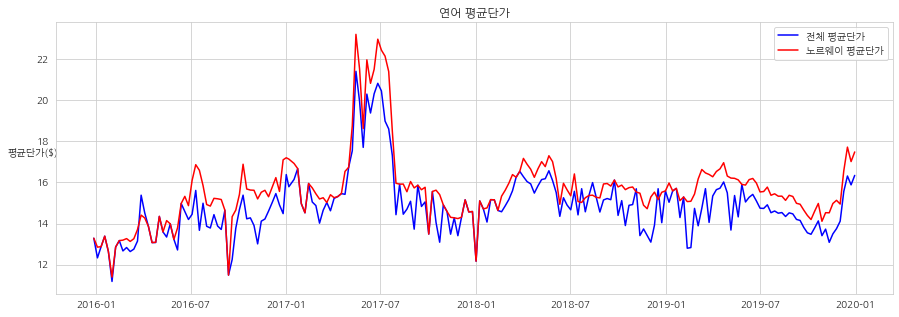

In [189]:
plt.figure(figsize=(15,5))

plt.title('연어 평균단가')

plt.plot(all_salmon_price,color='blue',label='전체 평균단가')
plt.plot(df_train[df_train['상세어종']=='연어'][df_train['수출국']=='노르웨이'].groupby(by='기준일').mean(),color='red',label='노르웨이 평균단가')

plt.legend(loc='best')
plt.ylabel('평균단가($)',rotation=0)

plt.show()

연어 평균단가는 **주요 수출국(노르웨이)의 평균단가와 높은 상관관계**를 가지는 듯함. (올라갈때 같이 올라가고 내려갈때 같이 내려감)

In [190]:
pd.DataFrame({'all':all_salmon_price,
             'norway':norway_salmon_price
             }).corr()

,all,norway
all,1.000000,0.917461
norway,0.917461,1.000000


실제로 연어 평균단가는 노르웨이 평균단가와 높은 상관관계를 띄고 있음.

In [191]:
all_salmon_count = df_train[df_train['상세어종']=='연어'].groupby(by='기준일')['상세어종'].count() # 전체 연어 수입량
norway_salmon_count = df_train[df_train['상세어종']=='연어'][df_train['수출국']=='노르웨이'].groupby(by='기준일')['상세어종'].count() # 노르웨이 연어 수입량

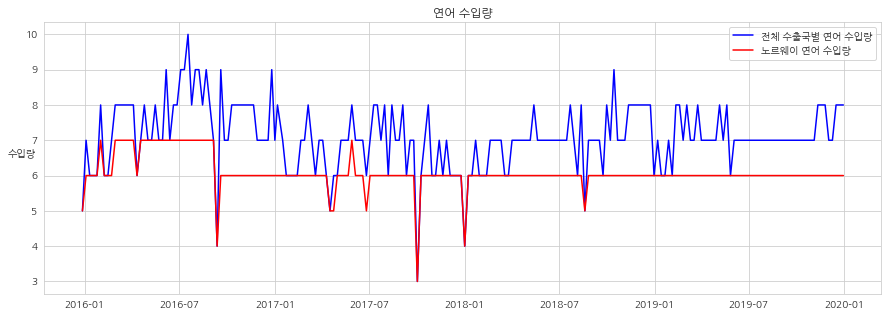

In [192]:
plt.figure(figsize=(15,5))

plt.title('연어 수입량')

plt.plot(all_salmon_count,color='blue',label='전체 수출국별 연어 수입량')
plt.plot(norway_salmon_count,color='red',label='노르웨이 연어 수입량')

plt.legend(loc='best')
plt.ylabel('수입량',rotation=0)

plt.show()

연어 수입량은 노르웨이 수입량과 높은 상관관계를 띄는 것으로 보임.

In [193]:
pd.DataFrame({'all':all_salmon_count,
             'norway':norway_salmon_count
             }).corr()

,all,norway
all,1.000000,0.637471
norway,0.637471,1.000000


실제로 연어 수입량은 노르웨이 수입량과 높은 상관관계를 띄고 있음.

연어 전체 평가
- 연어는 2017년에 갑자기 가격이 솟구치는 구간이 있다.
- 제조국과 수출국이 다를 때 가격을 알아보려했지만 연어는 제조국과 수출국이 다른 경우가 적다.
- 연어는 가격차이가 별로없는것같다. (2017년 제외)
- 치솟는 연어의 가격은 자사제품용, 노르웨이가 수출국일 때 나타났다.
- 연어의 import_type중 냉장,필렛(F),횟감은 16년도 자료밖에 없다.
- 냉동가격은 보통 낮다.
- 제일 비중이 많은 노르웨이 환율과 눈으로 비교해보았을때 별로 연관이 없는것같았다.
- 연어의 중국 수출? https://m.kati.net/board/exportNewsView.do?board_seq=85540&menu_dept2=35&menu_dept3=71
- 중국의 연어 수입 분석 https://www.giikorea.co.kr/report/cri949828-research-report-on-imported-salmon-china.html

#### 새우

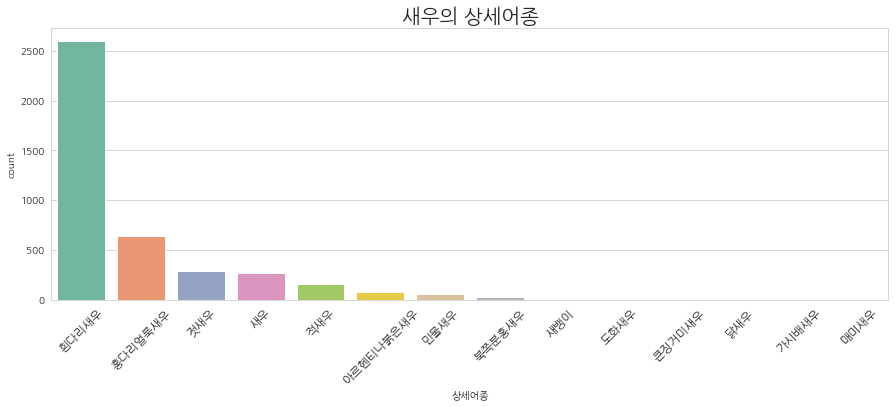

In [194]:
is_shrimp = df_train['어종'].str.contains("새우",na=False)
df_shrimp = df_train[is_shrimp]

plt.figure(figsize=(15,5))
sns.countplot(df_shrimp['상세어종'].astype('str').sort_values(), palette=color_palette, order= df_shrimp['상세어종'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우의 상세어종', fontsize=title_size)

plt.show()

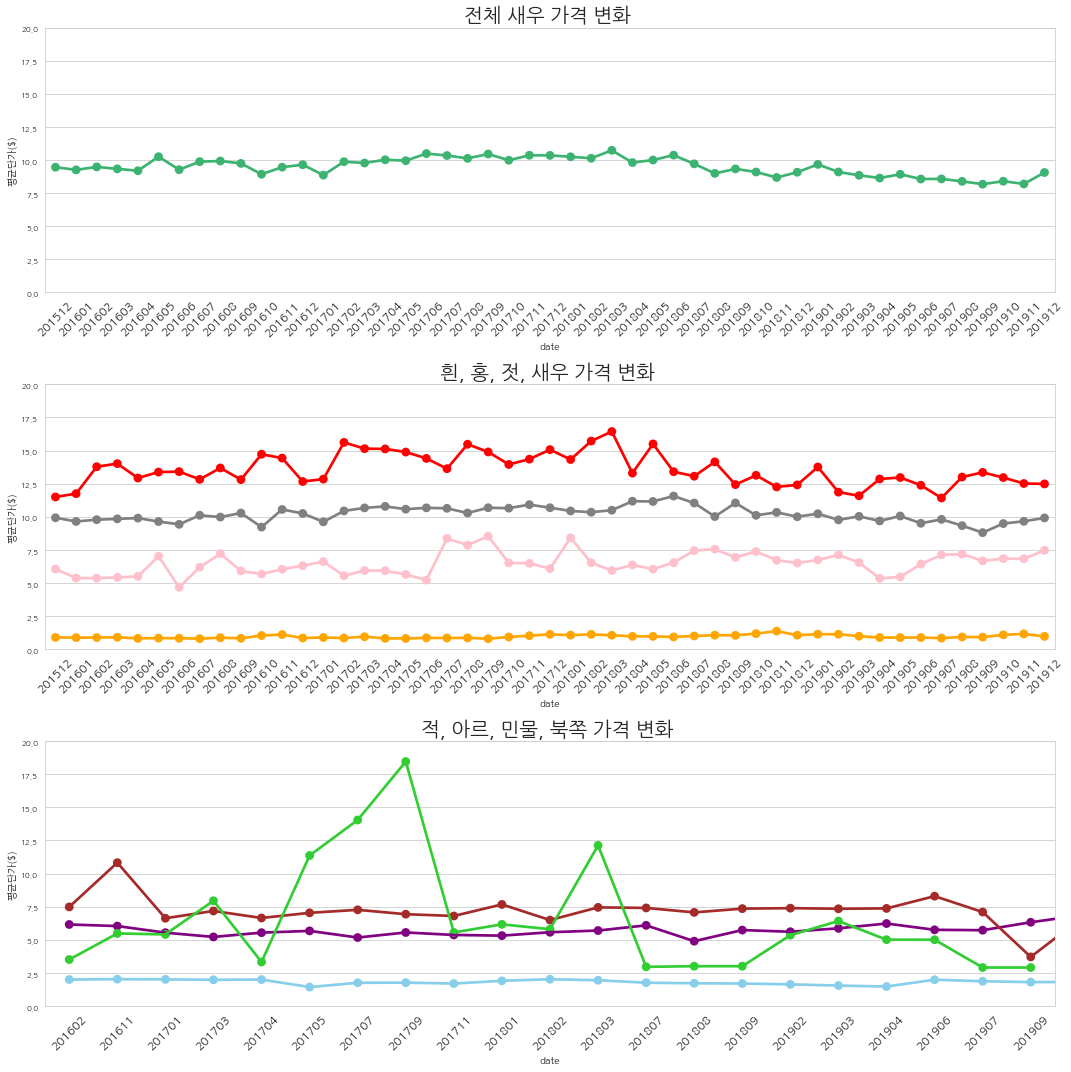

In [195]:
# 새우 품목별 그래프
# df_one = df_shrimp['P_PRICE'].groupby(df_shrimp['P_PURPOSE'])
# print("---size---")
# print(df_one.size())
# print("---sum---")
# print(df_one.sum())
# print("---mean---")
# print(df_one.mean())
# print("---median---")
# print(df_one.median())

plt.figure(figsize=(15, 15))

plt.subplot(311)
plt.title('전체 새우 가격 변화 ', fontsize=title_size)
plt.ylim(0,20)

sns.pointplot(x='date', y='평균단가($)', data=df_shrimp, ci=None, color='mediumseagreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)



plt.subplot(312)
plt.ylim(0,20)
plt.title('흰, 홍, 젓, 새우 가격 변화 ', fontsize=title_size)

sns.pointplot(x='date', y='평균단가($)', data = df_shrimp[df_shrimp['상세어종'].str.contains("흰다리",na=False)], ci=None, color='gray')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)

sns.pointplot(x='date', y='평균단가($)', data = df_shrimp[df_shrimp['상세어종'].str.contains("홍다리",na=False)], ci=None, color='red')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)

sns.pointplot(x='date', y='평균단가($)', data = df_shrimp[df_shrimp['상세어종'].str.contains("젓",na=False)], ci=None, color='orange')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)

sns.pointplot(x='date', y='평균단가($)', data = df_shrimp[df_shrimp['상세어종'].str.startswith("새우",na=False)], ci=None, color='pink')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)



plt.subplot(313)
plt.ylim(0,20)
plt.title('적, 아르, 민물, 북쪽 가격 변화 ', fontsize=title_size)

sns.pointplot(x='date', y='평균단가($)', data = df_shrimp[df_shrimp['상세어종'].str.startswith("적",na=False)], ci=None, color='purple')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)

sns.pointplot(x='date', y='평균단가($)', data = df_shrimp[df_shrimp['상세어종'].str.startswith("아르헨티나",na=False)], ci=None, color='brown')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)

sns.pointplot(x='date', y='평균단가($)', data = df_shrimp[df_shrimp['상세어종'].str.startswith("민물",na=False)], ci=None, color='skyblue')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)

sns.pointplot(x='date', y='평균단가($)', data = df_shrimp[df_shrimp['상세어종'].str.startswith("북쪽",na=False)], ci=None, color='limegreen')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=8)

plt.tight_layout()

In [196]:
df_shrimp[df_shrimp['상세어종'].str.startswith("북쪽",na=False)]

,기준일,제품구분,제조국,수출국,수입용도,중분류명 카테고리,어종,상세어종,수입형태,평균단가($),date
1390,2016-02-15,수산물,러시아,러시아,외화획득용 원료,갑각류,새우,북쪽분홍새우,냉동,3.505303,201602
8999,2016-11-21,수산물,캐나다,캐나다,판매용,갑각류,새우,북쪽분홍새우,"냉동,자숙",5.474953,201611
10871,2017-01-23,수산물,캐나다,캐나다,판매용,갑각류,새우,북쪽분홍새우,"냉동,자숙",5.401967,201701
12059,2017-03-06,수산물,러시아,러시아,외화획득용 원료,갑각류,새우,북쪽분홍새우,냉동,14.532194,201703
12414,2017-03-20,수산물,캐나다,캐나다,판매용,갑각류,새우,북쪽분홍새우,냉동,2.500000,201703
12653,2017-03-27,수산물,그린란드,덴마크,판매용,갑각류,새우,북쪽분홍새우,냉동,6.800000,201703
13464,2017-04-24,수산물,캐나다,덴마크,판매용,갑각류,새우,북쪽분홍새우,냉동,3.318054,201704
14507,2017-05-29,수산물,러시아,러시아,외화획득용 원료,갑각류,새우,북쪽분홍새우,냉동,11.364654,201705
16319,2017-07-31,수산물,러시아,러시아,외화획득용 원료,갑각류,새우,북쪽분홍새우,냉동,14.048261,201707
17459,2017-09-11,수산물,그린란드,스웨덴,판매용,갑각류,새우,북쪽분홍새우,"냉동,살,자숙",18.462400,201709


In [197]:
df_shrimp.제조국.value_counts()

베트남        1538
태국          857
중국          674
말레이시아       326
에콰도르        198
인도          162
인도네시아        91
아르헨티나        79
사우디아라비아      66
페루           49
필리핀          36
러시아          18
캐나다          12
미국            9
파나마           7
콜롬비아          4
기니            3
방글라데시         2
그린란드          2
시에라리온         2
소말리아          2
니카라과          1
모잠비크          1
노르웨이          1
대만            1
Name: 제조국, dtype: int64

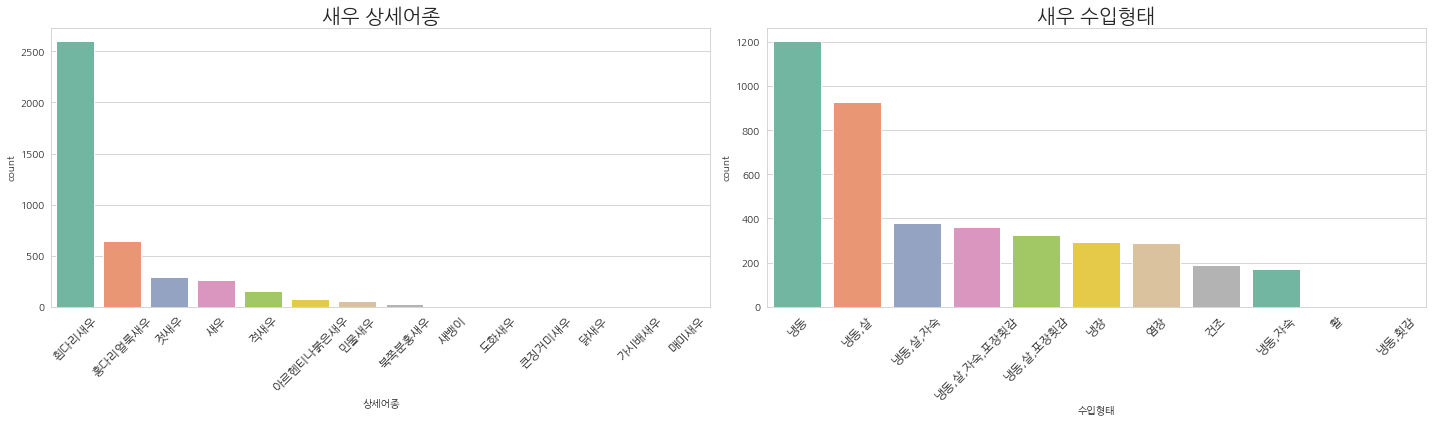

In [198]:
# df_one = df_shrimp['P_PRICE'].groupby(df_shrimp['CTRY_1'])
# print("---size---")
# print(df_one.size())
# print("---max---")
# print(df_one.max())
# print("---mean---")
# print(df_one.mean())
# print("---median---")
# print(df_one.median())

df_shrimp.loc[df_shrimp['제조국']==df_shrimp['수출국'], "comp"] = '같음'
df_shrimp.loc[df_shrimp['제조국']!=df_shrimp['수출국'], "comp"] = '다름'

plt.figure(figsize=(20, 10))

plt.subplot(221)
sns.countplot(df_shrimp['상세어종'].astype('str').sort_values(), palette=color_palette, order= df_shrimp['상세어종'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우 상세어종', fontsize=title_size)

plt.subplot(222)
sns.countplot(df_shrimp['수입형태'].astype('str').sort_values(), palette=color_palette, order= df_shrimp['수입형태'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우 수입형태', fontsize=title_size)

plt.tight_layout()

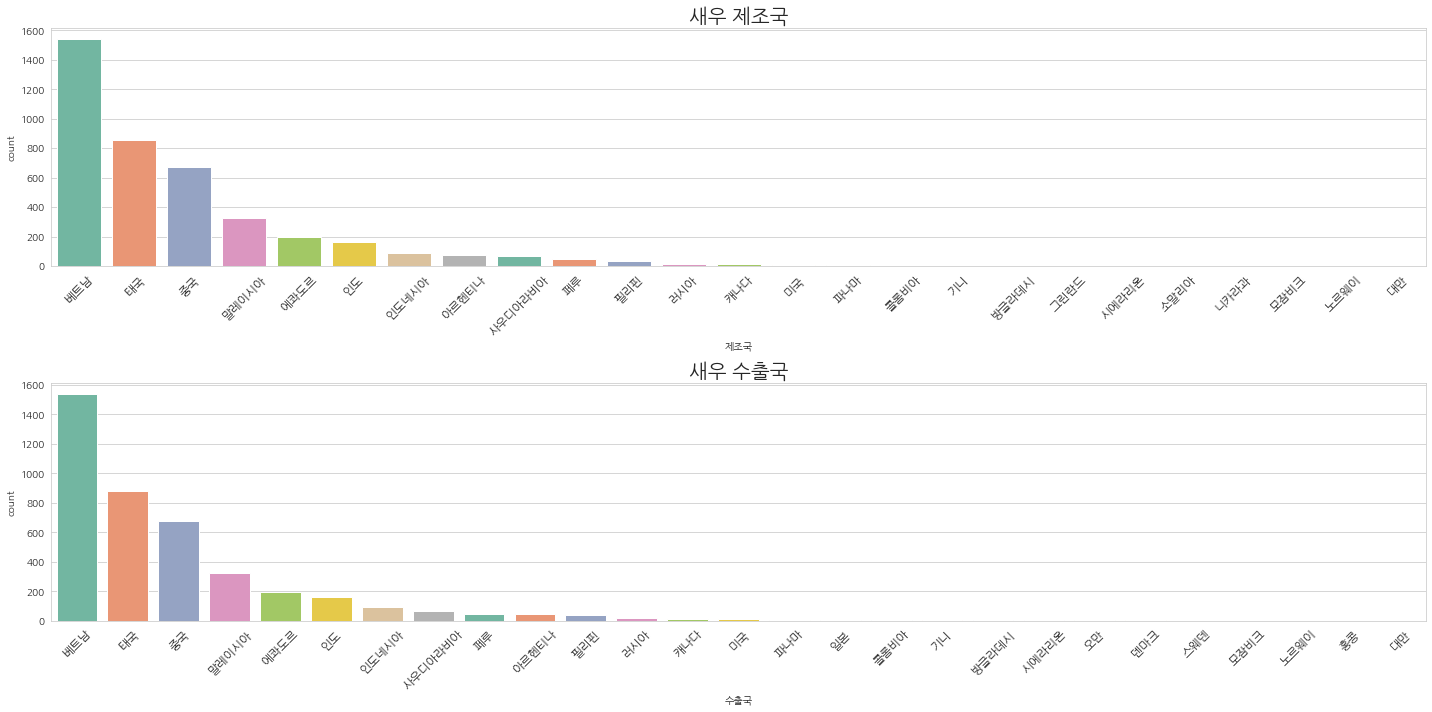

In [199]:
plt.figure(figsize=(20, 10))

plt.subplot(211)
sns.countplot(df_shrimp['제조국'].astype('str').sort_values(), palette=color_palette, order= df_shrimp['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우 제조국', fontsize=title_size)

plt.subplot(212)
sns.countplot(df_shrimp['수출국'].astype('str').sort_values(), palette=color_palette, order= df_shrimp['수출국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('새우 수출국', fontsize=title_size)

plt.tight_layout()

In [200]:
print(df_shrimp['comp'].value_counts())
df_shrimp_d = df_shrimp[df_shrimp.comp.str.contains("다름",na=False)]
df_shrimp_d

같음    4095
다름      46
Name: comp, dtype: int64


,기준일,제품구분,제조국,수출국,수입용도,중분류명 카테고리,어종,상세어종,수입형태,평균단가($),date,comp
415,2016-01-11,수산물,아르헨티나,태국,판매용,갑각류,새우,아르헨티나붉은새우,냉동,14.300020,201601,다름
1023,2016-02-01,수산물,아르헨티나,태국,판매용,갑각류,새우,아르헨티나붉은새우,냉동,6.100026,201602,다름
1753,2016-02-29,수산물,베트남,일본,판매용,갑각류,새우,흰다리새우,"냉동,살,자숙,포장횟감",21.521972,201602,다름
5675,2016-07-18,수산물,베트남,일본,판매용,갑각류,새우,흰다리새우,"냉동,살,자숙,포장횟감",24.579832,201607,다름
8804,2016-11-14,수산물,아르헨티나,베트남,판매용,갑각류,새우,아르헨티나붉은새우,"냉동,살",5.649722,201611,다름
9200,2016-11-28,수산물,아르헨티나,베트남,판매용,갑각류,새우,아르헨티나붉은새우,"냉동,살",6.500000,201611,다름
9465,2016-12-05,수산물,소말리아,오만,판매용,갑각류,새우,홍다리얼룩새우,냉동,3.800000,201612,다름
11067,2017-01-30,수산물,아르헨티나,베트남,판매용,갑각류,새우,아르헨티나붉은새우,"냉동,살",8.378111,201701,다름
11420,2017-02-13,수산물,중국,홍콩,판매용,갑각류,새우,민물새우,냉동,2.400000,201702,다름
11977,2017-03-06,수산물,아르헨티나,베트남,판매용,갑각류,새우,아르헨티나붉은새우,"냉동,살",7.955490,201703,다름


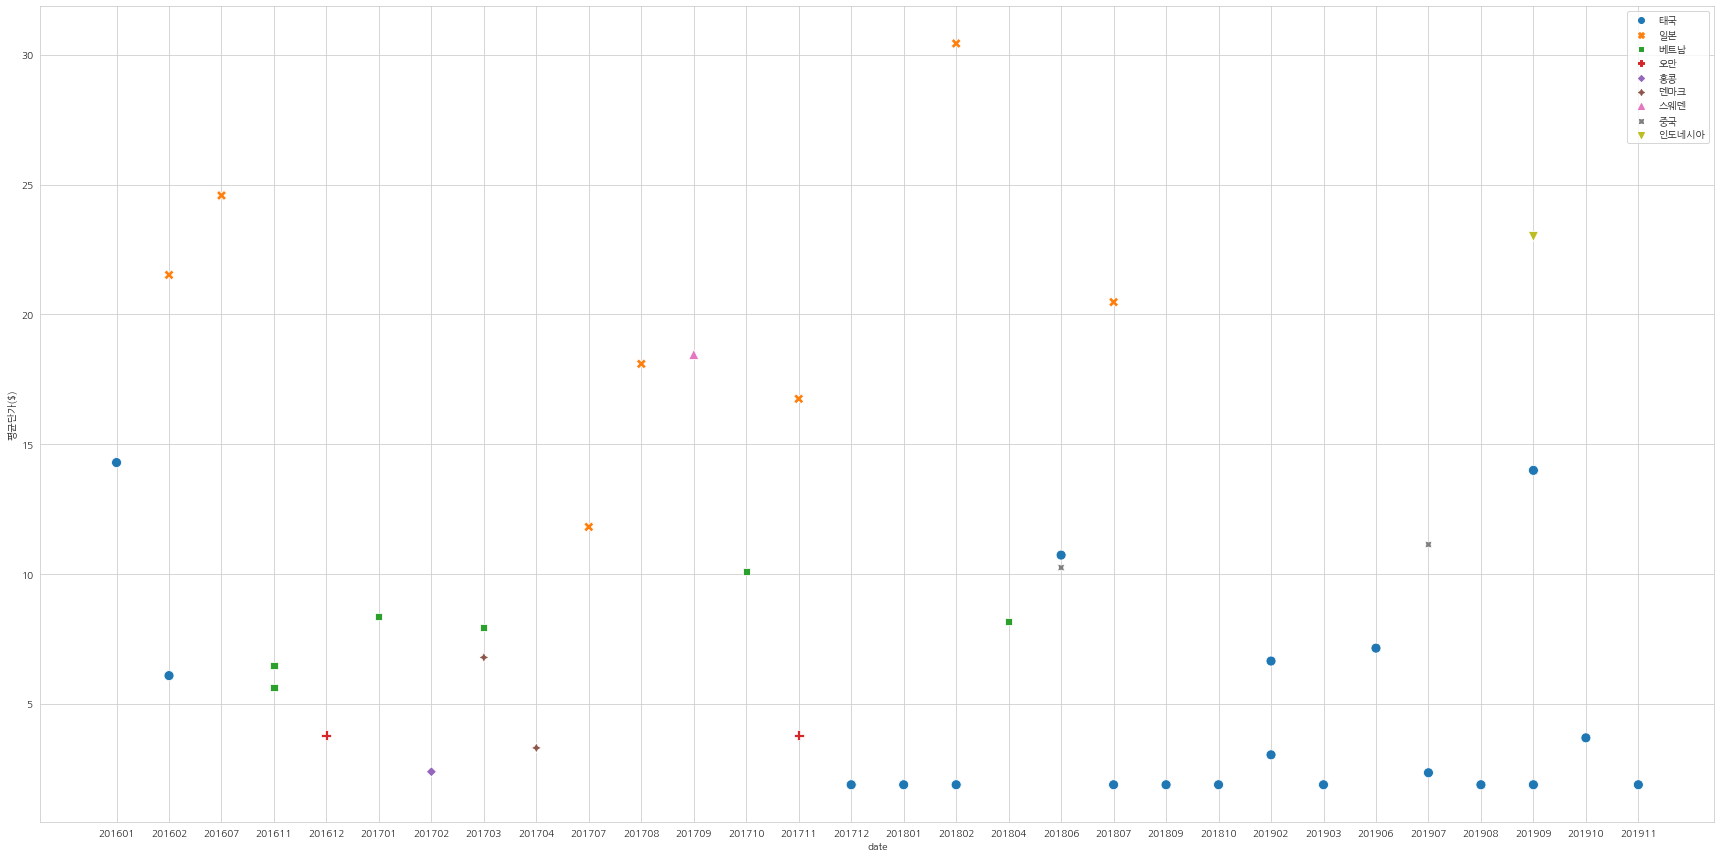

In [201]:
testdata = df_shrimp_d['평균단가($)'].groupby(df_shrimp_d['수출국'])
# print("---size---")
# print(testdata.size())
# print("---max---")
# print(testdata.max())
# print("---mean---")
# print(testdata.mean())
# print("---median---")
# print(testdata.median())

plt.figure(figsize=(30,15))

sns.scatterplot(x='date', 
                y='평균단가($)', 
                hue='수출국', # different colors by group
                style='수출국', # different shapes by group
                s=100, # marker size
                data=df_shrimp_d
                )

plt.legend(loc='best')
plt.show()

새우 평가
- 새우 종류가 많아서 보기가 너무 어렵다
- 북쪽분홍새우의 가격이 너무 왓다갓다 차이가 크다 하지만 총평균가격에서는 영향이 없을정도로 양이 작다.


- 각 제조국별로 max값과 차이가 많이나는거는 미국, 캐나다, 태국, 러시아, 베트남이 있다.
- 미국, 캐나다, 러시아는 영향없을정도로 적고 태국, 베트남을 눈여겨 봐야한다.
- 중국은 주요 수출국 3위인 반면 가격의 변화가 많이없다.


- 제조국, 수출국 비율은 비슷하다.
- 제조국, 수출국이 다른곳이 별로 없다.
- 제조국, 수출국이 다른곳의 가격은 평균대비 일본, 스웨덴, 태국이 비싸다.



#####  흰다리새우

In [202]:
df_train[df_train['상세어종']=='흰다리새우']['제조국'].value_counts()/sum(df_train[df_train['상세어종']=='흰다리새우']['제조국'].value_counts()) 

베트남        0.391388
태국         0.284890
에콰도르       0.076125
말레이시아      0.073433
중국         0.061899
인도         0.039600
사우디아라비아    0.025375
인도네시아      0.022684
페루         0.018839
파나마        0.002691
콜롬비아       0.001538
필리핀        0.001538
Name: 제조국, dtype: float64

In [203]:
df_train[df_train['상세어종']=='흰다리새우']['수출국'].value_counts()/sum(df_train[df_train['상세어종']=='흰다리새우']['수출국'].value_counts()) 

베트남        0.389466
태국         0.284890
에콰도르       0.076125
말레이시아      0.073433
중국         0.061899
인도         0.039600
사우디아라비아    0.025375
인도네시아      0.022684
페루         0.018839
파나마        0.002691
일본         0.001922
콜롬비아       0.001538
필리핀        0.001538
Name: 수출국, dtype: float64

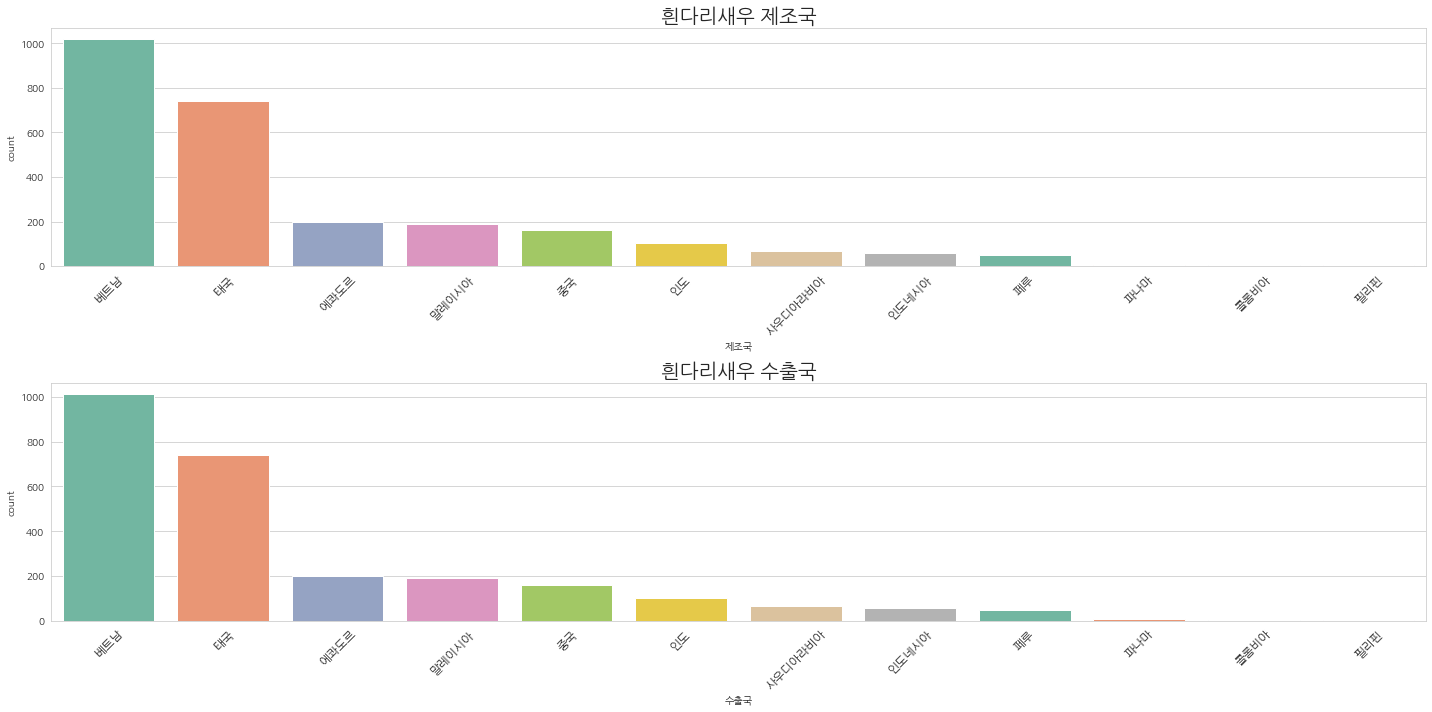

In [204]:
# 흰다리새우
plt.figure(figsize=(20, 10))

plt.subplot(211)
sns.countplot(df_train[df_train['상세어종']=='흰다리새우']['제조국'].astype('str').sort_values(), palette=color_palette, order= df_train[df_train['상세어종']=='흰다리새우']['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('흰다리새우 제조국', fontsize=title_size)

plt.subplot(212)
sns.countplot(df_train[df_train['상세어종']=='흰다리새우']['수출국'].astype('str').sort_values(), palette=color_palette, order= df_train[df_train['상세어종']=='흰다리새우']['제조국'].astype('str').value_counts().index)
plt.xticks(rotation=45, fontsize=12)
plt.title('흰다리새우 수출국', fontsize=title_size)

plt.tight_layout()

- 흰다리새우 제조국 및 수출국 점유율
- 흰다리새우 주요 제조국 및 수출국 : 베트남,태국(60%)

In [205]:
all_Whiteleg_shrimp_price = df_train[df_train['상세어종']=='흰다리새우'].groupby(by='기준일')['평균단가($)'].mean() # 전체 흰다리새우 평균단가
vitenam_Whiteleg_shrimp_price = df_train[df_train['상세어종']=='흰다리새우'][df_train['수출국']=='베트남'].groupby(by='기준일')['평균단가($)'].mean() # 베트남 흰다리새우 평균단가
thai_Whiteleg_shrimp_price = df_train[df_train['상세어종']=='흰다리새우'][df_train['수출국']=='태국'].groupby(by='기준일')['평균단가($)'].mean() # 태국 흰다리새우 평균단가

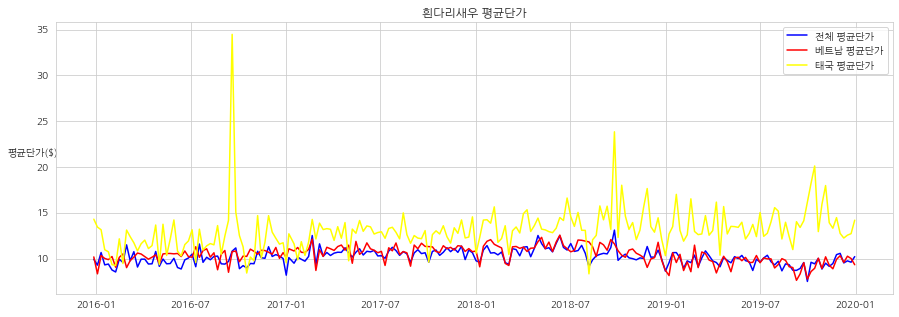

In [206]:
plt.figure(figsize=(15,5))

plt.title('흰다리새우 평균단가')

plt.plot(all_Whiteleg_shrimp_price,color='blue',label='전체 평균단가')
plt.plot(vitenam_Whiteleg_shrimp_price,color='red',label='베트남 평균단가')
plt.plot(thai_Whiteleg_shrimp_price,color='yellow',label='태국 평균단가')

plt.legend(loc='best')
plt.ylabel('평균단가($)',rotation=0)

plt.show()

흰다리새우 평균단가는 **주요 수출국들(베트남,태국)의 평균단가와 높은 상관관계**를 가지는 듯함

In [207]:
pd.DataFrame({'all':all_Whiteleg_shrimp_price,
             'vitenam':vitenam_Whiteleg_shrimp_price,
              'thai':thai_Whiteleg_shrimp_price
             }).corr() 

,all,vitenam,thai
all,1.000000,0.645756,0.378097
vitenam,0.645756,1.000000,-0.017934
thai,0.378097,-0.017934,1.000000


실제로 흰다리새우 평균단가는 베트남,태국 평균단가와 높은 상관관계를 띄고 있음.

In [208]:
all_Whiteleg_shrimp_count = df_train[df_train['상세어종']=='흰다리새우'].groupby(by='기준일')['상세어종'].count() # 전체 흰다리새우 수입량
vitenam_Whiteleg_shrimp_count = df_train[df_train['상세어종']=='흰다리새우'][df_train['수출국']=='베트남'].groupby(by='기준일')['상세어종'].count() # 베트남 흰다리새우 수입량
thai_Whiteleg_shrimp_count = df_train[df_train['상세어종']=='흰다리새우'][df_train['수출국']=='태국'].groupby(by='기준일')['상세어종'].count() # 태국 흰다리새우 수입량

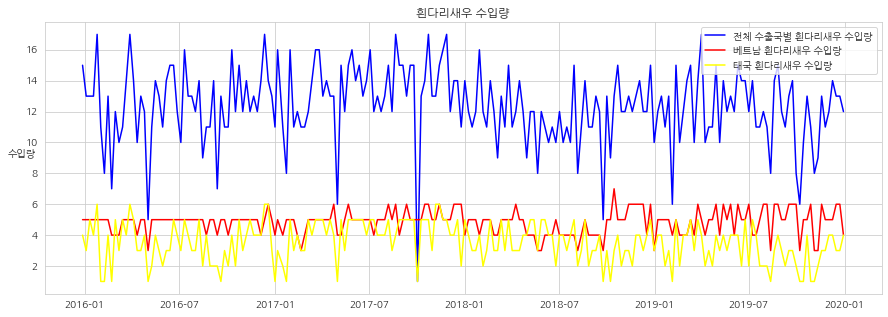

In [209]:
plt.figure(figsize=(15,5))

plt.title('흰다리새우 수입량')

plt.plot(all_Whiteleg_shrimp_count ,color='blue',label='전체 수출국별 흰다리새우 수입량')
plt.plot(vitenam_Whiteleg_shrimp_count ,color='red',label='베트남 흰다리새우 수입량')
plt.plot(thai_Whiteleg_shrimp_count,color='yellow',label='태국 흰다리새우 수입량')


plt.legend(loc='best')
plt.ylabel('수입량',rotation=0)

plt.show()

흰다리새우 수입량은 주요 수출국별(베트남,태국) 수입량과 높은 상관관계를 띄는 것으로 보임.

In [210]:
pd.DataFrame({'all':all_Whiteleg_shrimp_count,
             'vitenam':vitenam_Whiteleg_shrimp_count,
              'thai':thai_Whiteleg_shrimp_count
             }).corr()

,all,vitenam,thai
all,1.000000,0.490309,0.703371
vitenam,0.490309,1.000000,0.195590
thai,0.703371,0.195590,1.000000


실제로 흰다리새우 수입량은 주요 수출국별(베트남,태국) 수입량과 높은 상관관계를 띄는 것으로 보임.

### 시계열

#### Setting

In [211]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [212]:
def adf_test(y):
    print("Results of Augmented Dickey-Fuller test:")
    dftest = adfuller(y,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['test statistic','p-value','# of lags','# of observations'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

#### 오징어

In [213]:
adf_test(all_squid_price) # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -2.282189
p-value                   0.177777
# of lags                 4.000000
# of observations       203.000000
Critical Value (1%)      -3.462980
Critical Value (5%)      -2.875885
Critical Value (10%)     -2.574416
dtype: float64


In [214]:
adf_test(peru_squid_price) # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -2.834459
p-value                   0.053518
# of lags                14.000000
# of observations       182.000000
Critical Value (1%)      -3.466800
Critical Value (5%)      -2.877555
Critical Value (10%)     -2.575308
dtype: float64


In [215]:
adf_test(china_squid_price) # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -2.852497
p-value                   0.051157
# of lags                 4.000000
# of observations       188.000000
Critical Value (1%)      -3.465620
Critical Value (5%)      -2.877040
Critical Value (10%)     -2.575032
dtype: float64


In [216]:
adf_test(chile_squid_price) # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -1.817471
p-value                   0.371823
# of lags                 2.000000
# of observations       173.000000
Critical Value (1%)      -3.468726
Critical Value (5%)      -2.878396
Critical Value (10%)     -2.575756
dtype: float64


In [217]:
adf_test(all_squid_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -5.496217
p-value                   0.000002
# of lags                 1.000000
# of observations       206.000000
Critical Value (1%)      -3.462499
Critical Value (5%)      -2.875675
Critical Value (10%)     -2.574304
dtype: float64


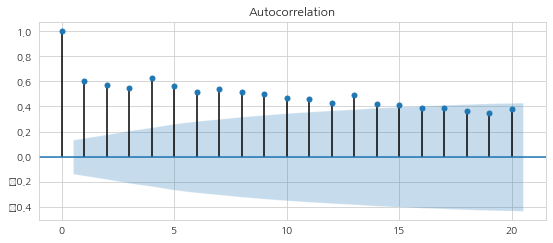

In [218]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_squid_price,lags=20,ax=ax1) # 0으로 느리게 감소 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

In [219]:
adf_test(peru_squid_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -3.474553
p-value                   0.008665
# of lags                 3.000000
# of observations       193.000000
Critical Value (1%)      -3.464694
Critical Value (5%)      -2.876635
Critical Value (10%)     -2.574816
dtype: float64


In [220]:
adf_test(china_squid_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -4.442649
p-value                   0.000249
# of lags                 1.000000
# of observations       191.000000
Critical Value (1%)      -3.465059
Critical Value (5%)      -2.876794
Critical Value (10%)     -2.574901
dtype: float64


In [221]:
adf_test(chile_squid_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -5.177519
p-value                   0.000010
# of lags                 2.000000
# of observations       173.000000
Critical Value (1%)      -3.468726
Critical Value (5%)      -2.878396
Critical Value (10%)     -2.575756
dtype: float64


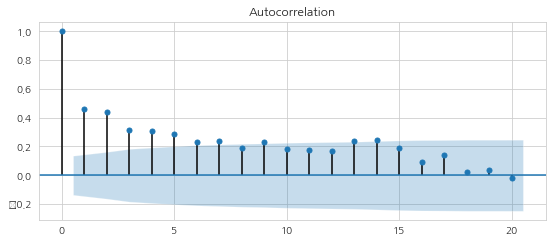

In [222]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_squid_count,lags=20,ax=ax1)

#### 연어

In [223]:
adf_test(all_salmon_price) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -3.402312
p-value                   0.010880
# of lags                 3.000000
# of observations       206.000000
Critical Value (1%)      -3.462499
Critical Value (5%)      -2.875675
Critical Value (10%)     -2.574304
dtype: float64


In [224]:
adf_test(norway_salmon_price) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -3.414652
p-value                   0.010469
# of lags                 3.000000
# of observations       206.000000
Critical Value (1%)      -3.462499
Critical Value (5%)      -2.875675
Critical Value (10%)     -2.574304
dtype: float64


In [225]:
adf_test(all_salmon_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -5.075966
p-value                   0.000016
# of lags                 2.000000
# of observations       207.000000
Critical Value (1%)      -3.462342
Critical Value (5%)      -2.875606
Critical Value (10%)     -2.574267
dtype: float64


In [226]:
adf_test(norway_salmon_count) # p-value가 0.05보다 크므로 귀무가설 기각 x -> 정상성 만족 x --> 로그 변환 or 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -2.509735
p-value                   0.113124
# of lags                 6.000000
# of observations       203.000000
Critical Value (1%)      -3.462980
Critical Value (5%)      -2.875885
Critical Value (10%)     -2.574416
dtype: float64


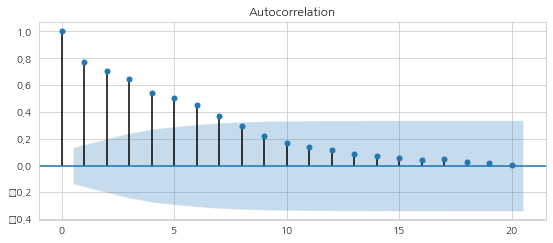

In [227]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_salmon_price,lags=20,ax=ax1) # 0으로 빠르게 감소 --> 정상성 만족

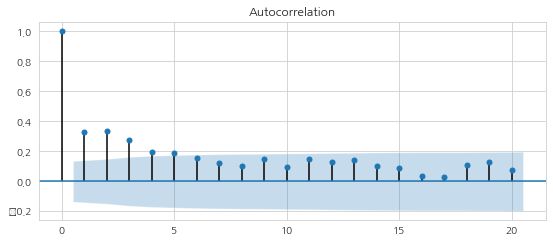

In [228]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_salmon_count,lags=20,ax=ax1)

#### 흰다리새우

In [229]:
adf_test(all_Whiteleg_shrimp_price) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -3.814197
p-value                   0.002765
# of lags                 3.000000
# of observations       206.000000
Critical Value (1%)      -3.462499
Critical Value (5%)      -2.875675
Critical Value (10%)     -2.574304
dtype: float64


In [230]:
adf_test(vitenam_Whiteleg_shrimp_price)  # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic           -1.599229
p-value                   0.483981
# of lags                 7.000000
# of observations       201.000000
Critical Value (1%)      -3.463309
Critical Value (5%)      -2.876029
Critical Value (10%)     -2.574493
dtype: float64


In [231]:
adf_test(thai_Whiteleg_shrimp_price)  # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic         -7.790862e+00
p-value                 7.949013e-12
# of lags               1.000000e+00
# of observations       2.070000e+02
Critical Value (1%)    -3.462342e+00
Critical Value (5%)    -2.875606e+00
Critical Value (10%)   -2.574267e+00
dtype: float64


In [232]:
adf_test(all_Whiteleg_shrimp_count)  # p-value가 0.05보다 크므로 귀무가설 기각 못함 -> 정상성 만족 x -> 로그 변환 혹은 차분 필요

Results of Augmented Dickey-Fuller test:
test statistic         -6.161200e+00
p-value                 7.166996e-08
# of lags               5.000000e+00
# of observations       2.040000e+02
Critical Value (1%)    -3.462818e+00
Critical Value (5%)    -2.875815e+00
Critical Value (10%)   -2.574379e+00
dtype: float64


In [233]:
adf_test(vitenam_Whiteleg_shrimp_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -4.583956
p-value                   0.000138
# of lags                 5.000000
# of observations       203.000000
Critical Value (1%)      -3.462980
Critical Value (5%)      -2.875885
Critical Value (10%)     -2.574416
dtype: float64


In [234]:
adf_test(thai_Whiteleg_shrimp_count) # p-value가 0.05보다 작으므로 귀무가설 기각 -> 정상성 만족

Results of Augmented Dickey-Fuller test:
test statistic           -5.279234
p-value                   0.000006
# of lags                 4.000000
# of observations       204.000000
Critical Value (1%)      -3.462818
Critical Value (5%)      -2.875815
Critical Value (10%)     -2.574379
dtype: float64


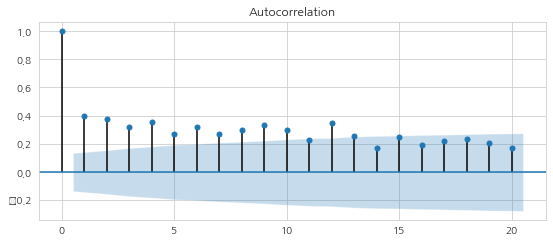

In [235]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_Whiteleg_shrimp_price,lags=20,ax=ax1)

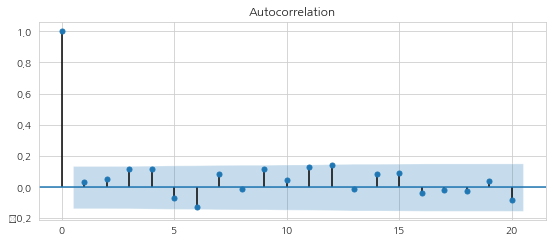

In [236]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(all_Whiteleg_shrimp_count,lags=20,ax=ax1)

분석 방향

1. 전체 제조국 및 수출국을 포함한 모델

2. 주요 수출국들(노르웨이,태국,베트남,중국,칠레,페루)만을 포함한 모델

3. 주요 수출국별 주요 어종 모델 (오징어, 연어, 흰다리새우)

4. 시계열 모델

위 4가지 모델로 분석을 진행하여 모델 검증을 통해 가장 설명력이 좋은 모델을 선택하여 수산물 가격 예측을 수행하고자 함.

# 상관관계

In [237]:
# k = 10 #number of variables for heatmap
# cols = df_corr.corr().nlargest(k, '평균단가($)')['평균단가($)'].index
# cm = np.corrcoef(df_corr[cols].values.T)
# plt.figure(figsize=(8, 8))
# plt.title('HeatMap', fontsize=title_size)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

In [238]:
# df_corr = pd.get_dummies(df_train, columns=['제조국', '수출국', '수입형태', '중분류명 카테고리', '어종'])